# Load libraries

In [ ]:
 #If using Google Colab, then run the following 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==2.11.0 keras==2.11.0 tensorflow-addons vit-keras tensorflow-hub

In [ ]:
####################################################################################################################

In [ ]:
#  If using Cloud Conda env, then run the following 

In [ ]:
!conda create -y -n myenv python=3.8

In [ ]:
conda activate myenv

In [ ]:
!pip install tensorflow==2.11.0 keras==2.11.0 tensorflow-addons vit-keras tensorflow-hub

In [1]:
# Load libraries
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from typing import Callable, Tuple
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.losses_utils import reduce_weighted_loss



# Prepare data

In [2]:
"""Constants for the data reader."""

# INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
#                   'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

INPUT_FEATURES = ['elevation', 'th', 'sph', 'pr', 'NDVI', 'PrevFireMask']


OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [3]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
        num_in_channels: number of channels in input_img.
        num_out_channels: number of channels in output_img.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
        combined,
        [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

In [4]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)

    raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
        tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
        for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    if clip_and_normalize:
        inputs_list = [
            _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
            _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]

    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
            input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
            input_img, output_img, sample_size)
    return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        batch_size: Batch size.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
          otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
          otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
        lambda x: _parse_fn(  # pylint: disable=g-long-lambda
            x, data_size, sample_size, num_in_channels, clip_and_normalize,
            clip_and_rescale, random_crop, center_crop),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [5]:
BATCH_SIZE = 32

train_dataset = get_dataset('/home/liang.zhimi/ondemand/northamerica_2012-2023/train/*_ongoing_*.tfrecord',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=6, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

validation_dataset = get_dataset('/home/liang.zhimi/ondemand/northamerica_2012-2023/val/*_ongoing_*.tfrecord',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=6, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

test_dataset = get_dataset('/home/liang.zhimi/ondemand/northamerica_2012-2023/test/*_ongoing_*.tfrecord',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=6, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Visualize data

In [14]:
# TITLES = [
#   'Elevation',
#   'Wind\ndirection',
#   'Wind\nvelocity',
#   'Min\ntemp',
#   'Max\ntemp',
#   'Humidity',
#   'Precip',
#   'Drought',
#   'Vegetation',
#   'Population\ndensity',
#   'Energy\nrelease\ncomponent',
#   'Previous\nfire\nmask',
#   'Fire\nmask'
# ]
TITLES = [
'elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask'
]


In [ ]:
def plot_sample_from_dataset(dataset: tf.data.Dataset):
    """
    Plot one row of samples from the dataset showing 12 features and fire mask.

    Args:
        dataset (tf.data.Dataset): Dataset from which to plot samples.
    """
    global TITLES

    # Get a batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break

    # Select the first sample
    sample_inputs = inputs[0]
    sample_label = labels[0]

    fig, axs = plt.subplots(1, 13, figsize=(25, 5))

    # Variables for controlling the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    for j in range(12):
        ax = axs[j]
        ax.imshow(sample_inputs[:, :, j], cmap='viridis')
        ax.set_title(TITLES[j], fontsize=13)
        ax.axis('off')
        # Add height and width annotations
        ax.text(0.5, -0.1, f'{sample_inputs.shape[0]}x{sample_inputs.shape[1]}', size=12, ha='center', transform=ax.transAxes)

    # Plot the fire mask
    ax = axs[12]
    ax.imshow(sample_label[:, :, 0], cmap=CMAP, norm=NORM)
    ax.set_title(TITLES[11], fontsize=13)
    ax.axis('off')
    # Add height and width annotations
    ax.text(0.5, -0.1, f'{sample_label.shape[0]}x{sample_label.shape[1]}', size=12, ha='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

# Example usage
plot_sample_from_dataset(train_dataset)

# Building testing

In [6]:
def IoU_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of intersection over union metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): IoU metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    intersection = np.logical_and(real_mask, predicted_mask)
    union = np.logical_or(real_mask, predicted_mask)

    if np.sum(union) == 0:
        return 1
    return np.sum(intersection) / np.sum(union)

def recall_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of recall metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): recall metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    actual_positives = np.sum(real_mask)
    if actual_positives == 0:
        return 1

    return true_positives / actual_positives

def precision_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of precision metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): precision metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    predicted_positives = np.sum(predicted_mask)
    if predicted_positives == 0:
        return 1

    return true_positives / predicted_positives

def f1_score(precision: float, recall: float) -> float:
    """
    Calculate the F1-score from precision and recall.
    
    Args:
        precision (float): The precision metric.
        recall (float): The recall metric.

    Returns:
        (float): The F1-score.
    """
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)


In [7]:
def dice_coef(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Dice loss function calculator.

    Args:
        y_true (Tensor):
        y_pred (Tensor):
    Returns:
        (Tensor): Dice loss for each element of a batch.
    """
    smooth = 1e-6
    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    intersection = K.sum(y_true_f * y_pred_f, axis=1)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)

def weighted_bincrossentropy(true: tf.Tensor, pred: tf.Tensor, weight_zero: float = 0.01, weight_one: float = 1) -> float:
    """
    Calculates weighted binary cross entropy. The weights are fixed.

    This can be useful for unbalanced catagories.

    Adjust the weights here depending on what is required.

    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives
        will be penalize 10 times as much as false negatives.

    Args:
        true (Tensor): Ground-truth values
        pred (Tensor): Predited values
        weight_zero (float): Weight of class 0 (no-fire)
        weight_one (float): Weight of class 1 (fire)

    """

    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)

    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy

    return K.mean(weighted_bin_crossentropy, axis=1)

def bce_dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor):
    """
    BCE loss function calculator.

    Args:
        y_true (Tensor):
        y_pred (Tensor):
    Returns:
        (Tensor): Mean BCE Dice loss over a batch.
    """

    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    return reduce_weighted_loss(weighted_bincrossentropy(y_true_f, y_pred_f) + dice_coef(y_true, y_pred))

In [8]:
def evaluate_model(prediction_function: Callable[[tf.Tensor], tf.Tensor],
                   eval_dataset: tf.data.Dataset) -> Tuple[float, float, float, float]:
    """
    Loads dataset according to file pattern and evaluates model's predictions on it.

    Parameters:
        model (Callable[[tf.Tensor], tf.Tensor]): Function for model inference.
        eval_dataset (tf.dataDataset): Dataset for evaluation.

    Returns:
        Tuple[float, float, float, float]: IoU score, recall score, precision score and mean loss.
    """
    IoU_measures = []
    recall_measures = []
    precision_measures = []
    losses = []

    for inputs, labels in tqdm(eval_dataset):
        # Prediction shape (N, W, H)
        predictions = prediction_function(inputs)
        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i, :, :,  0], predictions[i, :, :]))
            recall_measures.append(recall_metric(labels[i, :, :,  0], predictions[i, :, :]))
            precision_measures.append(precision_metric(labels[i, :, :,  0], predictions[i, :, :]))
        labels_cleared = tf.where(labels < 0, 0, labels)
        losses.append(bce_dice_loss(labels_cleared, tf.expand_dims(tf.cast(predictions, tf.float32), axis=-1)))

    mean_IoU = np.mean(IoU_measures)
    mean_recall = np.mean(recall_measures)
    mean_precision = np.mean(precision_measures)
    mean_loss = np.mean(losses)
    mean_f1 = f1_score(mean_precision, mean_recall)
    return mean_IoU, mean_recall, mean_precision, mean_f1, mean_loss

# Unet model

In [9]:
def conv_block(input_tensor, num_filters, num_layers=4):
    """
    Applies a series of convolutional layers with batch normalization and ReLU activation.

    Args:
        input_tensor (tf.Tensor): Input tensor to the block.
        num_filters (int): Number of filters for each convolutional layer.
        num_layers (int): Number of convolutional layers in the block.

    Returns:
        tf.Tensor: Output tensor after applying the convolutional block.
    """
    x = input_tensor
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

def encoder_block(input_tensor, num_filters):
    """
    Builds an encoder block consisting of a convolutional block followed by max pooling.

    Args:
        input_tensor (tf.Tensor): Input tensor to the block.
        num_filters (int): Number of filters for the convolutional block.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: 
            - Output tensor of the convolutional block.
            - Max-pooled tensor for further processing in the network.
    """
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """
    Builds a decoder block that upsamples the input tensor and concatenates it with a corresponding encoder block's output.

    Args:
        input_tensor (tf.Tensor): Input tensor to the block.
        concat_tensor (tf.Tensor): Tensor from the corresponding encoder block to concatenate.
        num_filters (int): Number of filters for the convolutional block.

    Returns:
        tf.Tensor: Output tensor after applying the decoder block.
    """
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(32, 32, 6), num_classes=1):
    """
    Constructs a U-Net model for image segmentation.

    Args:
        input_shape (Tuple[int, int, int]): Shape of the input image tensor.
        num_classes (int): Number of output classes.

    Returns:
        Model: A Keras Model object representing the U-Net architecture.
    """
    inputs = Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 64)  # 16 x 16
    c2, p2 = encoder_block(p1, 128)     # 8 x 8
    c3, p3 = encoder_block(p2, 256)     # 4 x 4

    # Bridge
    b = conv_block(p3, 512)

    # Decoder
    d3 = decoder_block(b, c3, 256)      # 8 x 8
    d2 = decoder_block(d3, c2, 128)     # 16 x 16
    d1 = decoder_block(d2, c1, 64)      # 32 x 32

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d1)

    model = Model(inputs, outputs)
    return model

# Build the model
model = build_unet()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 6)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   3520        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

# Train

In [ ]:
def train_model(model: Model, train_dataset: tf.data.Dataset, epochs:int=10) -> Tuple[List[float], List[float]]:
    """
    Trains a model using train dataset. (Save weights of model with best IoU)

    Args:
        model (Model): Model to train.
        train_dataset (Dataset): Training dataset.
        epochs (int): Number of epochs
    Returns:
        Tuple[List[float], List[float]]: Train losses and Validation losses
    """
    loss_fn = bce_dice_loss
    optimizer = tf.keras.optimizers.Adam()
    batch_losses = []
    val_losses = []
    best_IoU = 0.0

    for epoch in range(epochs):
        losses = []
        print(f'Epoch {epoch+1}/{epochs}')
        # Iterate through the dataset
        progress = tqdm(train_dataset)
        for images, masks in progress:
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = model(images, training=True)
                label = tf.where(masks < 0, 0, masks)
                # Compute the loss
                loss = loss_fn(label, predictions)
                losses.append(loss.numpy())
                progress.set_postfix({'batch_loss': loss.numpy()})
            # Compute gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            # Update the model's weights
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # Evaluate model
        print("Evaluation...")
        IoU, recall, precision, mean_f1, val_loss = evaluate_model(lambda x: tf.where(model.predict(x) > 0.5, 1, 0)[:,:,:,0], validation_dataset)
        print("Validation set metrics:")
        print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nMean F1: {mean_f1}\nValidation loss: {val_loss}\n")
        # Save best model
        if IoU > best_IoU:
            best_IoU = IoU
            model.save_weights("Unet_6Feature.h5")

        # Print the loss for monitoring
        print(f'Epoch: {epoch}, Train loss: {np.mean(losses)}')
        batch_losses.append(np.mean(losses))
        val_losses.append(val_loss)

    print(f"Best model IoU: {best_IoU}")
    return batch_losses, val_losses

# Set reproducability
tf.random.set_seed(1337)

segmentation_model = build_unet()
train_losses, val_losses = train_model(segmentation_model, train_dataset, epochs=15)

0it [00:00, ?it/s]

Epoch 1/15


993it [26:53,  1.62s/it, batch_loss=0.89] 
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 1s 568ms/step


1it [00:00,  1.43it/s]

1/1 [==============================] - 0s 242ms/step


2it [00:01,  2.13it/s]

1/1 [==============================] - 0s 245ms/step


3it [00:01,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


4it [00:01,  2.77it/s]

1/1 [==============================] - 0s 243ms/step


5it [00:01,  2.92it/s]

1/1 [==============================] - 0s 239ms/step


6it [00:02,  3.03it/s]

1/1 [==============================] - 0s 248ms/step


7it [00:02,  3.09it/s]

1/1 [==============================] - 0s 236ms/step


8it [00:02,  3.16it/s]

1/1 [==============================] - 0s 237ms/step


9it [00:03,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


10it [00:03,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


11it [00:03,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


12it [00:04,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


13it [00:04,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


14it [00:04,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


15it [00:05,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


16it [00:05,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


17it [00:05,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


18it [00:05,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


19it [00:06,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


20it [00:06,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


21it [00:06,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


22it [00:07,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


23it [00:07,  3.29it/s]

1/1 [==============================] - 0s 246ms/step


24it [00:07,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


25it [00:08,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


26it [00:08,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


27it [00:08,  3.30it/s]

1/1 [==============================] - 0s 247ms/step


28it [00:08,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


29it [00:09,  3.28it/s]

1/1 [==============================] - 0s 246ms/step


30it [00:09,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


31it [00:09,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


32it [00:10,  3.27it/s]

1/1 [==============================] - 0s 251ms/step


33it [00:10,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


34it [00:10,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


35it [00:11,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


36it [00:11,  3.26it/s]

1/1 [==============================] - 0s 249ms/step


37it [00:11,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


38it [00:12,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


39it [00:12,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


40it [00:12,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


41it [00:12,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


42it [00:13,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


43it [00:13,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


44it [00:13,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


45it [00:14,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


46it [00:14,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


47it [00:14,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


48it [00:15,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


49it [00:15,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


50it [00:15,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


51it [00:16,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


52it [00:16,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


53it [00:16,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


54it [00:16,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


55it [00:17,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


56it [00:17,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


57it [00:17,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


58it [00:18,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


59it [00:18,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


60it [00:18,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


61it [00:19,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


62it [00:19,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


63it [00:19,  3.27it/s]

1/1 [==============================] - 0s 247ms/step


64it [00:20,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


65it [00:20,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


66it [00:20,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


67it [00:20,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


68it [00:21,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


69it [00:21,  3.25it/s]

1/1 [==============================] - 0s 259ms/step


70it [00:21,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


71it [00:22,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


72it [00:22,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


73it [00:22,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


74it [00:23,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


75it [00:23,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


76it [00:23,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


77it [00:24,  3.23it/s]

1/1 [==============================] - 0s 249ms/step


78it [00:24,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


79it [00:24,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


80it [00:24,  3.23it/s]

1/1 [==============================] - 0s 249ms/step


81it [00:25,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


82it [00:25,  3.22it/s]

1/1 [==============================] - 0s 252ms/step


83it [00:25,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


84it [00:26,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


85it [00:26,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


86it [00:26,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


87it [00:27,  3.22it/s]

1/1 [==============================] - 0s 250ms/step


88it [00:27,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


89it [00:27,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


90it [00:28,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


91it [00:28,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


92it [00:28,  3.24it/s]

1/1 [==============================] - 0s 253ms/step


93it [00:29,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


94it [00:29,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


95it [00:29,  3.20it/s]

1/1 [==============================] - 0s 247ms/step


96it [00:29,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


97it [00:30,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


98it [00:30,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


99it [00:30,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


100it [00:31,  3.24it/s]

1/1 [==============================] - 0s 251ms/step


101it [00:31,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


102it [00:31,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


103it [00:32,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


104it [00:32,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


105it [00:32,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


106it [00:33,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


107it [00:33,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


108it [00:33,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


109it [00:33,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


110it [00:34,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


111it [00:34,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


112it [00:34,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


113it [00:35,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


114it [00:35,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


115it [00:35,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


116it [00:36,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


117it [00:36,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


118it [00:36,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


119it [00:37,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


120it [00:37,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


121it [00:37,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


122it [00:37,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


123it [00:38,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


124it [00:38,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


125it [00:38,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


126it [00:39,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


127it [00:39,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


128it [00:39,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


129it [00:40,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


130it [00:40,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


131it [00:40,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


132it [00:40,  3.25it/s]

1/1 [==============================] - 0s 250ms/step


133it [00:41,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


134it [00:41,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


135it [00:41,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


136it [00:42,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


137it [00:42,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


138it [00:42,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


139it [00:43,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


140it [00:43,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


141it [00:43,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


142it [00:44,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


143it [00:44,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


144it [00:44,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


145it [00:44,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


146it [00:45,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


147it [00:45,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


148it [00:45,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


149it [00:46,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


150it [00:46,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


151it [00:46,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


152it [00:47,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


153it [00:47,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


154it [00:47,  3.27it/s]

1/1 [==============================] - 0s 255ms/step


155it [00:48,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


156it [00:48,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


157it [00:48,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


158it [00:48,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


159it [00:49,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


160it [00:49,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


161it [00:49,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


162it [00:50,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


163it [00:50,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


164it [00:50,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


165it [00:51,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


166it [00:51,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


167it [00:51,  3.28it/s]

1/1 [==============================] - 0s 249ms/step


168it [00:52,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


169it [00:52,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


170it [00:52,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


171it [00:52,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


172it [00:53,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


173it [00:53,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


174it [00:53,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


175it [00:54,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


176it [00:54,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


177it [00:54,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


178it [00:55,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


179it [00:55,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


180it [00:55,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


181it [00:56,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


182it [00:56,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


183it [00:56,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


184it [00:56,  3.25it/s]

1/1 [==============================] - 0s 248ms/step


185it [00:57,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


186it [00:57,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


187it [00:57,  3.23it/s]

1/1 [==============================] - 0s 235ms/step


188it [00:58,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


189it [00:58,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


190it [00:58,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


191it [00:59,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


192it [00:59,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


193it [00:59,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


194it [01:00,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


195it [01:00,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


196it [01:00,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


197it [01:00,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


198it [01:01,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


199it [01:01,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


200it [01:01,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


201it [01:02,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


202it [01:02,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


203it [01:02,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


204it [01:03,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


205it [01:03,  3.29it/s]

1/1 [==============================] - 0s 247ms/step


206it [01:03,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


207it [01:04,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


208it [01:04,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


209it [01:04,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


210it [01:04,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


211it [01:05,  3.29it/s]

1/1 [==============================] - 0s 243ms/step


212it [01:05,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


213it [01:05,  3.29it/s]

1/1 [==============================] - 0s 243ms/step


214it [01:06,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


215it [01:06,  3.29it/s]

1/1 [==============================] - 0s 241ms/step


216it [01:06,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


217it [01:07,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


218it [01:07,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


219it [01:07,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


220it [01:07,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


221it [01:08,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


222it [01:08,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


223it [01:08,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


224it [01:09,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


225it [01:09,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


226it [01:09,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


227it [01:10,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


228it [01:10,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


229it [01:10,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


230it [01:11,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


231it [01:11,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


232it [01:11,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


233it [01:11,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


234it [01:12,  3.25it/s]

1/1 [==============================] - 0s 250ms/step


235it [01:12,  3.22it/s]

1/1 [==============================] - 0s 235ms/step


236it [01:12,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


237it [01:13,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


238it [01:13,  3.26it/s]

1/1 [==============================] - 0s 255ms/step


239it [01:13,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


240it [01:14,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


241it [01:14,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


242it [01:14,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


243it [01:15,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


244it [01:15,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


245it [01:15,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


246it [01:15,  3.25it/s]

1/1 [==============================] - 0s 250ms/step


247it [01:16,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


248it [01:16,  3.25it/s]

1/1 [==============================] - 0s 249ms/step


249it [01:16,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


250it [01:17,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


251it [01:17,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


252it [01:17,  3.25it/s]

1/1 [==============================] - 0s 234ms/step


253it [01:18,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


254it [01:18,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


255it [01:18,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


256it [01:19,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


257it [01:19,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


258it [01:19,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


259it [01:19,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


260it [01:20,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


261it [01:20,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


262it [01:20,  3.31it/s]

1/1 [==============================] - 0s 236ms/step


263it [01:21,  3.31it/s]

1/1 [==============================] - 0s 235ms/step


264it [01:21,  3.31it/s]

1/1 [==============================] - 0s 237ms/step


265it [01:21,  3.31it/s]

1/1 [==============================] - 0s 243ms/step


266it [01:22,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


267it [01:22,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


268it [01:22,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


269it [01:22,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


270it [01:23,  3.30it/s]

1/1 [==============================] - 0s 249ms/step


271it [01:23,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


272it [01:23,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


273it [01:24,  3.25it/s]

1/1 [==============================] - 0s 234ms/step


274it [01:24,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


275it [01:24,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


276it [01:25,  3.29it/s]

1/1 [==============================] - 0s 241ms/step


277it [01:25,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


278it [01:25,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


279it [01:26,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


280it [01:26,  3.27it/s]

1/1 [==============================] - 0s 246ms/step


281it [01:26,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


282it [01:26,  3.28it/s]

1/1 [==============================] - 0s 252ms/step


283it [01:27,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


284it [01:27,  3.24it/s]

1/1 [==============================] - 0s 247ms/step


285it [01:27,  3.23it/s]

1/1 [==============================] - 0s 248ms/step


286it [01:28,  3.22it/s]

1/1 [==============================] - 0s 236ms/step


287it [01:28,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


288it [01:28,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


289it [01:29,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


290it [01:29,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


291it [01:29,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


292it [01:30,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


293it [01:30,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


294it [01:30,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


295it [01:30,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


296it [01:31,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


297it [01:31,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


298it [01:31,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


299it [01:32,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


300it [01:32,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


301it [01:32,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


302it [01:33,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


303it [01:33,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


304it [01:33,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


305it [01:34,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


306it [01:34,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


307it [01:34,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


308it [01:34,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


309it [01:35,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


310it [01:35,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


311it [01:35,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


312it [01:36,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


313it [01:36,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


314it [01:36,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


315it [01:37,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


316it [01:37,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


317it [01:37,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


318it [01:37,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


319it [01:38,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


320it [01:38,  3.27it/s]

1/1 [==============================] - 0s 247ms/step


321it [01:38,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


322it [01:39,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


323it [01:39,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


324it [01:39,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


325it [01:40,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


326it [01:40,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


327it [01:40,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


328it [01:41,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


329it [01:41,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


330it [01:41,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


331it [01:41,  3.26it/s]

1/1 [==============================] - 0s 249ms/step


332it [01:42,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


333it [01:42,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


334it [01:42,  3.26it/s]

1/1 [==============================] - 0s 260ms/step


335it [01:43,  3.20it/s]

1/1 [==============================] - 0s 250ms/step


336it [01:43,  3.19it/s]

1/1 [==============================] - 0s 263ms/step


337it [01:43,  3.15it/s]

1/1 [==============================] - 0s 255ms/step


338it [01:44,  3.14it/s]

1/1 [==============================] - 0s 249ms/step


339it [01:44,  3.15it/s]

1/1 [==============================] - 0s 262ms/step


340it [01:44,  3.11it/s]

1/1 [==============================] - 0s 248ms/step


341it [01:45,  3.12it/s]

1/1 [==============================] - 0s 308ms/step


342it [01:45,  2.98it/s]

1/1 [==============================] - 0s 251ms/step


343it [01:45,  3.03it/s]

1/1 [==============================] - 0s 254ms/step


344it [01:46,  3.06it/s]

1/1 [==============================] - 0s 236ms/step


345it [01:46,  3.13it/s]

1/1 [==============================] - 0s 238ms/step


346it [01:46,  3.18it/s]

1/1 [==============================] - 0s 235ms/step


347it [01:47,  3.22it/s]

1/1 [==============================] - 0s 235ms/step


348it [01:47,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


349it [01:47,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


350it [01:47,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


351it [01:48,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


352it [01:48,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


353it [01:48,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


354it [01:49,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


355it [01:49,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


356it [01:49,  3.29it/s]

1/1 [==============================] - 0s 437ms/step


357it [01:50,  3.24it/s]
0it [00:00, ?it/s]

Validation set metrics:
Mean IoU: 0.19854811562236713
Mean precision: 0.43719133007566213
Mean recall: 0.4790411420910117
Mean F1: 0.4571604705877207
Validation loss: 0.9944227337837219

Epoch: 0, Train loss: 0.8429466485977173
Epoch 2/15


993it [28:21,  1.71s/it, batch_loss=1]    
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 0s 241ms/step


1it [00:00,  2.81it/s]

1/1 [==============================] - 0s 241ms/step


2it [00:00,  3.05it/s]

1/1 [==============================] - 0s 243ms/step


3it [00:00,  3.12it/s]

1/1 [==============================] - 0s 240ms/step


4it [00:01,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


5it [00:01,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


6it [00:01,  3.20it/s]

1/1 [==============================] - 0s 245ms/step


7it [00:02,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


8it [00:02,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


9it [00:02,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


10it [00:03,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


11it [00:03,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


12it [00:03,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


13it [00:04,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


14it [00:04,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


15it [00:04,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


16it [00:04,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


17it [00:05,  3.26it/s]

1/1 [==============================] - 0s 250ms/step


18it [00:05,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


19it [00:05,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


20it [00:06,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


21it [00:06,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


22it [00:06,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


23it [00:07,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


24it [00:07,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


25it [00:07,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


26it [00:08,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


27it [00:08,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


28it [00:08,  3.26it/s]

1/1 [==============================] - 0s 250ms/step


29it [00:08,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


30it [00:09,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


31it [00:09,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


32it [00:09,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


33it [00:10,  3.26it/s]

1/1 [==============================] - 0s 248ms/step


34it [00:10,  3.24it/s]

1/1 [==============================] - 0s 250ms/step


35it [00:10,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


36it [00:11,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


37it [00:11,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


38it [00:11,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


39it [00:12,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


40it [00:12,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


41it [00:12,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


42it [00:12,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


43it [00:13,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


44it [00:13,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


45it [00:13,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


46it [00:14,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


47it [00:14,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


48it [00:14,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


49it [00:15,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


50it [00:15,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


51it [00:15,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


52it [00:15,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


53it [00:16,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


54it [00:16,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


55it [00:16,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


56it [00:17,  3.26it/s]

1/1 [==============================] - 0s 301ms/step


57it [00:17,  3.08it/s]

1/1 [==============================] - 0s 243ms/step


58it [00:17,  3.13it/s]

1/1 [==============================] - 0s 245ms/step


59it [00:18,  3.16it/s]

1/1 [==============================] - 0s 245ms/step


60it [00:18,  3.18it/s]

1/1 [==============================] - 0s 250ms/step


61it [00:18,  3.18it/s]

1/1 [==============================] - 0s 247ms/step


62it [00:19,  3.19it/s]

1/1 [==============================] - 0s 248ms/step


63it [00:19,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


64it [00:19,  3.19it/s]

1/1 [==============================] - 0s 265ms/step


65it [00:20,  3.13it/s]

1/1 [==============================] - 0s 250ms/step


66it [00:20,  3.14it/s]

1/1 [==============================] - 0s 252ms/step


67it [00:20,  3.13it/s]

1/1 [==============================] - 0s 253ms/step


68it [00:21,  3.13it/s]

1/1 [==============================] - 0s 249ms/step


69it [00:21,  3.14it/s]

1/1 [==============================] - 0s 255ms/step


70it [00:21,  3.13it/s]

1/1 [==============================] - 0s 236ms/step


71it [00:22,  3.19it/s]

1/1 [==============================] - 0s 238ms/step


72it [00:22,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


73it [00:22,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


74it [00:22,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


75it [00:23,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


76it [00:23,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


77it [00:23,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


78it [00:24,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


79it [00:24,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


80it [00:24,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


81it [00:25,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


82it [00:25,  3.24it/s]

1/1 [==============================] - 0s 260ms/step


83it [00:25,  3.17it/s]

1/1 [==============================] - 0s 243ms/step


84it [00:26,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


85it [00:26,  3.21it/s]

1/1 [==============================] - 0s 245ms/step


86it [00:26,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


87it [00:26,  3.22it/s]

1/1 [==============================] - 0s 252ms/step


88it [00:27,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


89it [00:27,  3.21it/s]

1/1 [==============================] - 0s 253ms/step


90it [00:27,  3.19it/s]

1/1 [==============================] - 0s 249ms/step


91it [00:28,  3.19it/s]

1/1 [==============================] - 0s 258ms/step


92it [00:28,  3.16it/s]

1/1 [==============================] - 0s 249ms/step


93it [00:28,  3.15it/s]

1/1 [==============================] - 0s 263ms/step


94it [00:29,  3.12it/s]

1/1 [==============================] - 0s 247ms/step


95it [00:29,  3.14it/s]

1/1 [==============================] - 0s 249ms/step


96it [00:29,  3.15it/s]

1/1 [==============================] - 0s 255ms/step


97it [00:30,  3.14it/s]

1/1 [==============================] - 0s 252ms/step


98it [00:30,  3.13it/s]

1/1 [==============================] - 0s 244ms/step


99it [00:30,  3.16it/s]

1/1 [==============================] - 0s 261ms/step


100it [00:31,  3.13it/s]

1/1 [==============================] - 0s 257ms/step


101it [00:31,  3.12it/s]

1/1 [==============================] - 0s 247ms/step


102it [00:31,  3.14it/s]

1/1 [==============================] - 0s 252ms/step


103it [00:32,  3.12it/s]

1/1 [==============================] - 0s 259ms/step


104it [00:32,  3.10it/s]

1/1 [==============================] - 0s 246ms/step


105it [00:32,  3.13it/s]

1/1 [==============================] - 0s 248ms/step


106it [00:32,  3.14it/s]

1/1 [==============================] - 0s 252ms/step


107it [00:33,  3.15it/s]

1/1 [==============================] - 0s 247ms/step


108it [00:33,  3.17it/s]

1/1 [==============================] - 0s 246ms/step


109it [00:33,  3.18it/s]

1/1 [==============================] - 0s 247ms/step


110it [00:34,  3.18it/s]

1/1 [==============================] - 0s 244ms/step


111it [00:34,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


112it [00:34,  3.20it/s]

1/1 [==============================] - 0s 247ms/step


113it [00:35,  3.18it/s]

1/1 [==============================] - 0s 256ms/step


114it [00:35,  3.15it/s]

1/1 [==============================] - 0s 250ms/step


115it [00:35,  3.14it/s]

1/1 [==============================] - 0s 247ms/step


116it [00:36,  3.15it/s]

1/1 [==============================] - 0s 248ms/step


117it [00:36,  3.16it/s]

1/1 [==============================] - 0s 250ms/step


118it [00:36,  3.15it/s]

1/1 [==============================] - 0s 268ms/step


119it [00:37,  3.10it/s]

1/1 [==============================] - 0s 249ms/step


120it [00:37,  3.11it/s]

1/1 [==============================] - 0s 250ms/step


121it [00:37,  3.13it/s]

1/1 [==============================] - 0s 250ms/step


122it [00:38,  3.12it/s]

1/1 [==============================] - 0s 248ms/step


123it [00:38,  3.14it/s]

1/1 [==============================] - 0s 246ms/step


124it [00:38,  3.16it/s]

1/1 [==============================] - 0s 255ms/step


125it [00:39,  3.15it/s]

1/1 [==============================] - 0s 258ms/step


126it [00:39,  3.13it/s]

1/1 [==============================] - 0s 248ms/step


127it [00:39,  3.14it/s]

1/1 [==============================] - 0s 243ms/step


128it [00:39,  3.17it/s]

1/1 [==============================] - 0s 245ms/step


129it [00:40,  3.18it/s]

1/1 [==============================] - 0s 248ms/step


130it [00:40,  3.18it/s]

1/1 [==============================] - 0s 255ms/step


131it [00:40,  3.15it/s]

1/1 [==============================] - 0s 245ms/step


132it [00:41,  3.17it/s]

1/1 [==============================] - 0s 245ms/step


133it [00:41,  3.17it/s]

1/1 [==============================] - 0s 246ms/step


134it [00:41,  3.18it/s]

1/1 [==============================] - 0s 250ms/step


135it [00:42,  3.16it/s]

1/1 [==============================] - 0s 256ms/step


136it [00:42,  3.15it/s]

1/1 [==============================] - 0s 249ms/step


137it [00:42,  3.16it/s]

1/1 [==============================] - 0s 253ms/step


138it [00:43,  3.14it/s]

1/1 [==============================] - 0s 259ms/step


139it [00:43,  3.12it/s]

1/1 [==============================] - 0s 255ms/step


140it [00:43,  3.12it/s]

1/1 [==============================] - 0s 248ms/step


141it [00:44,  3.13it/s]

1/1 [==============================] - 0s 259ms/step


142it [00:44,  3.11it/s]

1/1 [==============================] - 0s 255ms/step


143it [00:44,  3.10it/s]

1/1 [==============================] - 0s 240ms/step


144it [00:45,  3.14it/s]

1/1 [==============================] - 0s 244ms/step


145it [00:45,  3.17it/s]

1/1 [==============================] - 0s 243ms/step


146it [00:45,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


147it [00:45,  3.20it/s]

1/1 [==============================] - 0s 249ms/step


148it [00:46,  3.20it/s]

1/1 [==============================] - 0s 245ms/step


149it [00:46,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


150it [00:46,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


151it [00:47,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


152it [00:47,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


153it [00:47,  3.23it/s]

1/1 [==============================] - 0s 251ms/step


154it [00:48,  3.20it/s]

1/1 [==============================] - 0s 250ms/step


155it [00:48,  3.18it/s]

1/1 [==============================] - 0s 239ms/step


156it [00:48,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


157it [00:49,  3.23it/s]

1/1 [==============================] - 0s 250ms/step


158it [00:49,  3.21it/s]

1/1 [==============================] - 0s 245ms/step


159it [00:49,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


160it [00:50,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


161it [00:50,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


162it [00:50,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


163it [00:50,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


164it [00:51,  3.27it/s]

1/1 [==============================] - 0s 246ms/step


165it [00:51,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


166it [00:51,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


167it [00:52,  3.26it/s]

1/1 [==============================] - 0s 249ms/step


168it [00:52,  3.24it/s]

1/1 [==============================] - 0s 260ms/step


169it [00:52,  3.19it/s]

1/1 [==============================] - 0s 303ms/step


170it [00:53,  3.03it/s]

1/1 [==============================] - 0s 301ms/step


171it [00:53,  2.93it/s]

1/1 [==============================] - 0s 304ms/step


172it [00:53,  2.86it/s]

1/1 [==============================] - 0s 305ms/step


173it [00:54,  2.81it/s]

1/1 [==============================] - 0s 312ms/step


174it [00:54,  2.76it/s]

1/1 [==============================] - 0s 305ms/step


175it [00:55,  2.74it/s]

1/1 [==============================] - 0s 278ms/step


176it [00:55,  2.79it/s]

1/1 [==============================] - 0s 238ms/step


177it [00:55,  2.93it/s]

1/1 [==============================] - 0s 250ms/step


178it [00:55,  3.00it/s]

1/1 [==============================] - 0s 273ms/step


179it [00:56,  2.98it/s]

1/1 [==============================] - 0s 272ms/step


180it [00:56,  2.97it/s]

1/1 [==============================] - 0s 260ms/step


181it [00:56,  2.99it/s]

1/1 [==============================] - 0s 292ms/step


182it [00:57,  2.93it/s]

1/1 [==============================] - 0s 261ms/step


183it [00:57,  2.97it/s]

1/1 [==============================] - 0s 262ms/step


184it [00:58,  2.98it/s]

1/1 [==============================] - 0s 259ms/step


185it [00:58,  3.01it/s]

1/1 [==============================] - 0s 262ms/step


186it [00:58,  3.02it/s]

1/1 [==============================] - 0s 268ms/step


187it [00:59,  3.01it/s]

1/1 [==============================] - 0s 277ms/step


188it [00:59,  2.98it/s]

1/1 [==============================] - 0s 297ms/step


189it [00:59,  2.90it/s]

1/1 [==============================] - 0s 263ms/step


190it [01:00,  2.94it/s]

1/1 [==============================] - 0s 245ms/step


191it [01:00,  3.02it/s]

1/1 [==============================] - 0s 271ms/step


192it [01:00,  3.00it/s]

1/1 [==============================] - 0s 266ms/step


193it [01:01,  3.00it/s]

1/1 [==============================] - 0s 268ms/step


194it [01:01,  2.99it/s]

1/1 [==============================] - 0s 266ms/step


195it [01:01,  3.00it/s]

1/1 [==============================] - 0s 276ms/step


196it [01:02,  2.97it/s]

1/1 [==============================] - 0s 258ms/step


197it [01:02,  3.01it/s]

1/1 [==============================] - 0s 252ms/step


198it [01:02,  3.05it/s]

1/1 [==============================] - 0s 264ms/step


199it [01:03,  3.03it/s]

1/1 [==============================] - 0s 269ms/step


200it [01:03,  3.01it/s]

1/1 [==============================] - 0s 276ms/step


201it [01:03,  2.98it/s]

1/1 [==============================] - 0s 263ms/step


202it [01:04,  3.00it/s]

1/1 [==============================] - 0s 281ms/step


203it [01:04,  2.96it/s]

1/1 [==============================] - 0s 258ms/step


204it [01:04,  2.99it/s]

1/1 [==============================] - 0s 288ms/step


205it [01:05,  2.93it/s]

1/1 [==============================] - 0s 262ms/step


206it [01:05,  2.97it/s]

1/1 [==============================] - 0s 278ms/step


207it [01:05,  2.95it/s]

1/1 [==============================] - 0s 283ms/step


208it [01:06,  2.91it/s]

1/1 [==============================] - 0s 294ms/step


209it [01:06,  2.86it/s]

1/1 [==============================] - 0s 260ms/step


210it [01:06,  2.92it/s]

1/1 [==============================] - 0s 268ms/step


211it [01:07,  2.93it/s]

1/1 [==============================] - 0s 274ms/step


212it [01:07,  2.93it/s]

1/1 [==============================] - 0s 265ms/step


213it [01:07,  2.96it/s]

1/1 [==============================] - 0s 273ms/step


214it [01:08,  2.95it/s]

1/1 [==============================] - 0s 265ms/step


215it [01:08,  2.97it/s]

1/1 [==============================] - 0s 274ms/step


216it [01:08,  2.95it/s]

1/1 [==============================] - 0s 275ms/step


217it [01:09,  2.94it/s]

1/1 [==============================] - 0s 239ms/step


218it [01:09,  3.01it/s]

1/1 [==============================] - 0s 245ms/step


219it [01:09,  3.07it/s]

1/1 [==============================] - 0s 245ms/step


220it [01:10,  3.12it/s]

1/1 [==============================] - 0s 241ms/step


221it [01:10,  3.16it/s]

1/1 [==============================] - 0s 241ms/step


222it [01:10,  3.18it/s]

1/1 [==============================] - 0s 243ms/step


223it [01:10,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


224it [01:11,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


225it [01:11,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


226it [01:11,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


227it [01:12,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


228it [01:12,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


229it [01:12,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


230it [01:13,  3.24it/s]

1/1 [==============================] - 0s 255ms/step


231it [01:13,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


232it [01:13,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


233it [01:14,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


234it [01:14,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


235it [01:14,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


236it [01:15,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


237it [01:15,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


238it [01:15,  3.20it/s]

1/1 [==============================] - 0s 247ms/step


239it [01:15,  3.19it/s]

1/1 [==============================] - 0s 238ms/step


240it [01:16,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


241it [01:16,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


242it [01:16,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


243it [01:17,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


244it [01:17,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


245it [01:17,  3.24it/s]

1/1 [==============================] - 0s 254ms/step


246it [01:18,  3.20it/s]

1/1 [==============================] - 0s 247ms/step


247it [01:18,  3.19it/s]

1/1 [==============================] - 0s 257ms/step


248it [01:18,  3.16it/s]

1/1 [==============================] - 0s 254ms/step


249it [01:19,  3.15it/s]

1/1 [==============================] - 0s 245ms/step


250it [01:19,  3.17it/s]

1/1 [==============================] - 0s 244ms/step


251it [01:19,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


252it [01:20,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


253it [01:20,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


254it [01:20,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


255it [01:20,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


256it [01:21,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


257it [01:21,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


258it [01:21,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


259it [01:22,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


260it [01:22,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


261it [01:22,  3.24it/s]

1/1 [==============================] - 0s 254ms/step


262it [01:23,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


263it [01:23,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


264it [01:23,  3.22it/s]

1/1 [==============================] - 0s 249ms/step


265it [01:24,  3.20it/s]

1/1 [==============================] - 0s 249ms/step


266it [01:24,  3.18it/s]

1/1 [==============================] - 0s 244ms/step


267it [01:24,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


268it [01:24,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


269it [01:25,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


270it [01:25,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


271it [01:25,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


272it [01:26,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


273it [01:26,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


274it [01:26,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


275it [01:27,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


276it [01:27,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


277it [01:27,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


278it [01:28,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


279it [01:28,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


280it [01:28,  3.24it/s]

1/1 [==============================] - 0s 247ms/step


281it [01:29,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


282it [01:29,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


283it [01:29,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


284it [01:29,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


285it [01:30,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


286it [01:30,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


287it [01:30,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


288it [01:31,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


289it [01:31,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


290it [01:31,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


291it [01:32,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


292it [01:32,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


293it [01:32,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


294it [01:33,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


295it [01:33,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


296it [01:33,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


297it [01:33,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


298it [01:34,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


299it [01:34,  3.24it/s]

1/1 [==============================] - 0s 250ms/step


300it [01:34,  3.22it/s]

1/1 [==============================] - 0s 253ms/step


301it [01:35,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


302it [01:35,  3.20it/s]

1/1 [==============================] - 0s 245ms/step


303it [01:35,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


304it [01:36,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


305it [01:36,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


306it [01:36,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


307it [01:37,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


308it [01:37,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


309it [01:37,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


310it [01:37,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


311it [01:38,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


312it [01:38,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


313it [01:38,  3.27it/s]

1/1 [==============================] - 0s 246ms/step


314it [01:39,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


315it [01:39,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


316it [01:39,  3.24it/s]

1/1 [==============================] - 0s 251ms/step


317it [01:40,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


318it [01:40,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


319it [01:40,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


320it [01:41,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


321it [01:41,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


322it [01:41,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


323it [01:41,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


324it [01:42,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


325it [01:42,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


326it [01:42,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


327it [01:43,  3.24it/s]

1/1 [==============================] - 0s 252ms/step


328it [01:43,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


329it [01:43,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


330it [01:44,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


331it [01:44,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


332it [01:44,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


333it [01:45,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


334it [01:45,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


335it [01:45,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


336it [01:46,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


337it [01:46,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


338it [01:46,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


339it [01:46,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


340it [01:47,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


341it [01:47,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


342it [01:47,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


343it [01:48,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


344it [01:48,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


345it [01:48,  3.25it/s]

1/1 [==============================] - 0s 252ms/step


346it [01:49,  3.21it/s]

1/1 [==============================] - 0s 293ms/step


347it [01:49,  3.06it/s]

1/1 [==============================] - 0s 261ms/step


348it [01:49,  3.06it/s]

1/1 [==============================] - 0s 246ms/step


349it [01:50,  3.09it/s]

1/1 [==============================] - 0s 237ms/step


350it [01:50,  3.15it/s]

1/1 [==============================] - 0s 242ms/step


351it [01:50,  3.18it/s]

1/1 [==============================] - 0s 244ms/step


352it [01:51,  3.18it/s]

1/1 [==============================] - 0s 239ms/step


353it [01:51,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


354it [01:51,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


355it [01:51,  3.23it/s]

1/1 [==============================] - 0s 247ms/step


356it [01:52,  3.22it/s]

1/1 [==============================] - 0s 144ms/step


357it [01:52,  3.17it/s]
0it [00:00, ?it/s]

Validation set metrics:
Mean IoU: 0.19846940224612925
Mean precision: 0.4335164480830256
Mean recall: 0.47995534056765016
Mean F1: 0.4555554688529847
Validation loss: 0.9874554872512817

Epoch: 1, Train loss: 0.8212552666664124
Epoch 3/15


993it [28:21,  1.71s/it, batch_loss=0.953]
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 0s 243ms/step


1it [00:00,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


2it [00:00,  3.02it/s]

1/1 [==============================] - 0s 245ms/step


3it [00:00,  3.09it/s]

1/1 [==============================] - 0s 238ms/step


4it [00:01,  3.14it/s]

1/1 [==============================] - 0s 237ms/step


5it [00:01,  3.19it/s]

1/1 [==============================] - 0s 238ms/step


6it [00:01,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


7it [00:02,  3.18it/s]

1/1 [==============================] - 0s 246ms/step


8it [00:02,  3.18it/s]

1/1 [==============================] - 0s 248ms/step


9it [00:02,  3.17it/s]

1/1 [==============================] - 0s 251ms/step


10it [00:03,  3.15it/s]

1/1 [==============================] - 0s 236ms/step


11it [00:03,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


12it [00:03,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


13it [00:04,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


14it [00:04,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


15it [00:04,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


16it [00:05,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


17it [00:05,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


18it [00:05,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


19it [00:05,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


20it [00:06,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


21it [00:06,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


22it [00:06,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


23it [00:07,  3.26it/s]

1/1 [==============================] - 0s 248ms/step


24it [00:07,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


25it [00:07,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


26it [00:08,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


27it [00:08,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


28it [00:08,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


29it [00:09,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


30it [00:09,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


31it [00:09,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


32it [00:09,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


33it [00:10,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


34it [00:10,  3.31it/s]

1/1 [==============================] - 0s 239ms/step


35it [00:10,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


36it [00:11,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


37it [00:11,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


38it [00:11,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


39it [00:12,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


40it [00:12,  3.30it/s]

1/1 [==============================] - 0s 242ms/step


41it [00:12,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


42it [00:12,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


43it [00:13,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


44it [00:13,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


45it [00:13,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


46it [00:14,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


47it [00:14,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


48it [00:14,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


49it [00:15,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


50it [00:15,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


51it [00:15,  3.27it/s]

1/1 [==============================] - 0s 248ms/step


52it [00:16,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


53it [00:16,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


54it [00:16,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


55it [00:16,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


56it [00:17,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


57it [00:17,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


58it [00:17,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


59it [00:18,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


60it [00:18,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


61it [00:18,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


62it [00:19,  3.28it/s]

1/1 [==============================] - 0s 248ms/step


63it [00:19,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


64it [00:19,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


65it [00:20,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


66it [00:20,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


67it [00:20,  3.29it/s]

1/1 [==============================] - 0s 255ms/step


68it [00:20,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


69it [00:21,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


70it [00:21,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


71it [00:21,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


72it [00:22,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


73it [00:22,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


74it [00:22,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


75it [00:23,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


76it [00:23,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


77it [00:23,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


78it [00:24,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


79it [00:24,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


80it [00:24,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


81it [00:24,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


82it [00:25,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


83it [00:25,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


84it [00:25,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


85it [00:26,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


86it [00:26,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


87it [00:26,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


88it [00:27,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


89it [00:27,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


90it [00:27,  3.28it/s]

1/1 [==============================] - 0s 234ms/step


91it [00:27,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


92it [00:28,  3.31it/s]

1/1 [==============================] - 0s 235ms/step


93it [00:28,  3.31it/s]

1/1 [==============================] - 0s 238ms/step


94it [00:28,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


95it [00:29,  3.31it/s]

1/1 [==============================] - 0s 241ms/step


96it [00:29,  3.30it/s]

1/1 [==============================] - 0s 243ms/step


97it [00:29,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


98it [00:30,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


99it [00:30,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


100it [00:30,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


101it [00:31,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


102it [00:31,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


103it [00:31,  3.29it/s]

1/1 [==============================] - 0s 241ms/step


104it [00:31,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


105it [00:32,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


106it [00:32,  3.29it/s]

1/1 [==============================] - 0s 243ms/step


107it [00:32,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


108it [00:33,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


109it [00:33,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


110it [00:33,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


111it [00:34,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


112it [00:34,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


113it [00:34,  3.24it/s]

1/1 [==============================] - 0s 235ms/step


114it [00:35,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


115it [00:35,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


116it [00:35,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


117it [00:35,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


118it [00:36,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


119it [00:36,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


120it [00:36,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


121it [00:37,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


122it [00:37,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


123it [00:37,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


124it [00:38,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


125it [00:38,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


126it [00:38,  3.31it/s]

1/1 [==============================] - 0s 239ms/step


127it [00:38,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


128it [00:39,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


129it [00:39,  3.31it/s]

1/1 [==============================] - 0s 239ms/step


130it [00:39,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


131it [00:40,  3.31it/s]

1/1 [==============================] - 0s 237ms/step


132it [00:40,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


133it [00:40,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


134it [00:41,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


135it [00:41,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


136it [00:41,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


137it [00:41,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


138it [00:42,  3.29it/s]

1/1 [==============================] - 0s 245ms/step


139it [00:42,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


140it [00:42,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


141it [00:43,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


142it [00:43,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


143it [00:43,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


144it [00:44,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


145it [00:44,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


146it [00:44,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


147it [00:45,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


148it [00:45,  3.31it/s]

1/1 [==============================] - 0s 244ms/step


149it [00:45,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


150it [00:45,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


151it [00:46,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


152it [00:46,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


153it [00:46,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


154it [00:47,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


155it [00:47,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


156it [00:47,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


157it [00:48,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


158it [00:48,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


159it [00:48,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


160it [00:49,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


161it [00:49,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


162it [00:49,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


163it [00:49,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


164it [00:50,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


165it [00:50,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


166it [00:50,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


167it [00:51,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


168it [00:51,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


169it [00:51,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


170it [00:52,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


171it [00:52,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


172it [00:52,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


173it [00:52,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


174it [00:53,  3.28it/s]

1/1 [==============================] - 0s 248ms/step


175it [00:53,  3.25it/s]

1/1 [==============================] - 0s 247ms/step


176it [00:53,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


177it [00:54,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


178it [00:54,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


179it [00:54,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


180it [00:55,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


181it [00:55,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


182it [00:55,  3.26it/s]

1/1 [==============================] - 0s 252ms/step


183it [00:56,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


184it [00:56,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


185it [00:56,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


186it [00:56,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


187it [00:57,  3.29it/s]

1/1 [==============================] - 0s 241ms/step


188it [00:57,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


189it [00:57,  3.25it/s]

1/1 [==============================] - 0s 250ms/step


190it [00:58,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


191it [00:58,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


192it [00:58,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


193it [00:59,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


194it [00:59,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


195it [00:59,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


196it [01:00,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


197it [01:00,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


198it [01:00,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


199it [01:00,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


200it [01:01,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


201it [01:01,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


202it [01:01,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


203it [01:02,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


204it [01:02,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


205it [01:02,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


206it [01:03,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


207it [01:03,  3.29it/s]

1/1 [==============================] - 0s 245ms/step


208it [01:03,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


209it [01:04,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


210it [01:04,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


211it [01:04,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


212it [01:04,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


213it [01:05,  3.25it/s]

1/1 [==============================] - 0s 249ms/step


214it [01:05,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


215it [01:05,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


216it [01:06,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


217it [01:06,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


218it [01:06,  3.23it/s]

1/1 [==============================] - 0s 235ms/step


219it [01:07,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


220it [01:07,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


221it [01:07,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


222it [01:08,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


223it [01:08,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


224it [01:08,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


225it [01:08,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


226it [01:09,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


227it [01:09,  3.28it/s]

1/1 [==============================] - 0s 234ms/step


228it [01:09,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


229it [01:10,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


230it [01:10,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


231it [01:10,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


232it [01:11,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


233it [01:11,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


234it [01:11,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


235it [01:12,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


236it [01:12,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


237it [01:12,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


238it [01:13,  2.92it/s]

1/1 [==============================] - 0s 296ms/step


239it [01:13,  2.86it/s]

1/1 [==============================] - 0s 239ms/step


240it [01:13,  2.97it/s]

1/1 [==============================] - 0s 241ms/step


241it [01:14,  3.05it/s]

1/1 [==============================] - 0s 236ms/step


242it [01:14,  3.12it/s]

1/1 [==============================] - 0s 238ms/step


243it [01:14,  3.17it/s]

1/1 [==============================] - 0s 249ms/step


244it [01:14,  3.17it/s]

1/1 [==============================] - 0s 245ms/step


245it [01:15,  3.18it/s]

1/1 [==============================] - 0s 241ms/step


246it [01:15,  3.20it/s]

1/1 [==============================] - 0s 236ms/step


247it [01:15,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


248it [01:16,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


249it [01:16,  3.21it/s]

1/1 [==============================] - 0s 321ms/step


250it [01:16,  2.99it/s]

1/1 [==============================] - 0s 311ms/step


251it [01:17,  2.87it/s]

1/1 [==============================] - 0s 305ms/step


252it [01:17,  2.77it/s]

1/1 [==============================] - 0s 482ms/step


253it [01:18,  2.39it/s]

1/1 [==============================] - 1s 551ms/step


254it [01:18,  2.07it/s]

1/1 [==============================] - 0s 493ms/step


255it [01:19,  1.97it/s]

1/1 [==============================] - 1s 526ms/step


256it [01:20,  1.83it/s]

1/1 [==============================] - 0s 464ms/step


257it [01:20,  1.83it/s]

1/1 [==============================] - 0s 351ms/step


258it [01:21,  1.97it/s]

1/1 [==============================] - 0s 431ms/step


259it [01:21,  1.98it/s]

1/1 [==============================] - 0s 249ms/step


260it [01:21,  2.24it/s]

1/1 [==============================] - 0s 237ms/step


261it [01:22,  2.48it/s]

1/1 [==============================] - 0s 237ms/step


262it [01:22,  2.68it/s]

1/1 [==============================] - 0s 236ms/step


263it [01:22,  2.85it/s]

1/1 [==============================] - 0s 236ms/step


264it [01:23,  2.97it/s]

1/1 [==============================] - 0s 237ms/step


265it [01:23,  3.07it/s]

1/1 [==============================] - 0s 245ms/step


266it [01:23,  3.10it/s]

1/1 [==============================] - 0s 244ms/step


267it [01:23,  3.14it/s]

1/1 [==============================] - 0s 236ms/step


268it [01:24,  3.19it/s]

1/1 [==============================] - 0s 236ms/step


269it [01:24,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


270it [01:24,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


271it [01:25,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


272it [01:25,  3.28it/s]

1/1 [==============================] - 0s 248ms/step


273it [01:25,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


274it [01:26,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


275it [01:26,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


276it [01:26,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


277it [01:27,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


278it [01:27,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


279it [01:27,  3.30it/s]

1/1 [==============================] - 0s 234ms/step


280it [01:27,  3.32it/s]

1/1 [==============================] - 0s 236ms/step


281it [01:28,  3.32it/s]

1/1 [==============================] - 0s 243ms/step


282it [01:28,  3.30it/s]

1/1 [==============================] - 0s 234ms/step


283it [01:28,  3.32it/s]

1/1 [==============================] - 0s 238ms/step


284it [01:29,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


285it [01:29,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


286it [01:29,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


287it [01:30,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


288it [01:30,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


289it [01:30,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


290it [01:30,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


291it [01:31,  3.30it/s]

1/1 [==============================] - 0s 245ms/step


292it [01:31,  3.28it/s]

1/1 [==============================] - 0s 246ms/step


293it [01:31,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


294it [01:32,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


295it [01:32,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


296it [01:32,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


297it [01:33,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


298it [01:33,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


299it [01:33,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


300it [01:34,  3.29it/s]

1/1 [==============================] - 0s 247ms/step


301it [01:34,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


302it [01:34,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


303it [01:34,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


304it [01:35,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


305it [01:35,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


306it [01:35,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


307it [01:36,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


308it [01:36,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


309it [01:36,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


310it [01:37,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


311it [01:37,  3.29it/s]

1/1 [==============================] - 0s 243ms/step


312it [01:37,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


313it [01:37,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


314it [01:38,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


315it [01:38,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


316it [01:38,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


317it [01:39,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


318it [01:39,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


319it [01:39,  3.31it/s]

1/1 [==============================] - 0s 237ms/step


320it [01:40,  3.31it/s]

1/1 [==============================] - 0s 235ms/step


321it [01:40,  3.32it/s]

1/1 [==============================] - 0s 247ms/step


322it [01:40,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


323it [01:41,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


324it [01:41,  3.29it/s]

1/1 [==============================] - 0s 244ms/step


325it [01:41,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


326it [01:41,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


327it [01:42,  3.29it/s]

1/1 [==============================] - 0s 234ms/step


328it [01:42,  3.31it/s]

1/1 [==============================] - 0s 247ms/step


329it [01:42,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


330it [01:43,  3.29it/s]

1/1 [==============================] - 0s 245ms/step


331it [01:43,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


332it [01:43,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


333it [01:44,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


334it [01:44,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


335it [01:44,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


336it [01:44,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


337it [01:45,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


338it [01:45,  3.31it/s]

1/1 [==============================] - 0s 236ms/step


339it [01:45,  3.31it/s]

1/1 [==============================] - 0s 251ms/step


340it [01:46,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


341it [01:46,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


342it [01:46,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


343it [01:47,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


344it [01:47,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


345it [01:47,  3.29it/s]

1/1 [==============================] - 0s 248ms/step


346it [01:48,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


347it [01:48,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


348it [01:48,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


349it [01:48,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


350it [01:49,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


351it [01:49,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


352it [01:49,  3.30it/s]

1/1 [==============================] - 0s 243ms/step


353it [01:50,  3.29it/s]

1/1 [==============================] - 0s 243ms/step


354it [01:50,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


355it [01:50,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


356it [01:51,  3.30it/s]

1/1 [==============================] - 0s 141ms/step


357it [01:51,  3.21it/s]
0it [00:00, ?it/s]

Validation set metrics:
Mean IoU: 0.19055775542379852
Mean precision: 0.40680263134786865
Mean recall: 0.5339759740180311
Mean F1: 0.461793731422264
Validation loss: 0.9493573904037476

Epoch: 2, Train loss: 0.8185043334960938
Epoch 4/15


993it [30:57,  1.87s/it, batch_loss=0.809]
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 0s 241ms/step


1it [00:00,  2.85it/s]

1/1 [==============================] - 0s 241ms/step


2it [00:00,  3.07it/s]

1/1 [==============================] - 0s 239ms/step


3it [00:00,  3.15it/s]

1/1 [==============================] - 0s 239ms/step


4it [00:01,  3.18it/s]

1/1 [==============================] - 0s 299ms/step


5it [00:01,  2.99it/s]

1/1 [==============================] - 0s 242ms/step


6it [00:01,  3.07it/s]

1/1 [==============================] - 0s 242ms/step


7it [00:02,  3.10it/s]

1/1 [==============================] - 0s 244ms/step


8it [00:02,  3.13it/s]

1/1 [==============================] - 0s 238ms/step


9it [00:02,  3.18it/s]

1/1 [==============================] - 0s 236ms/step


10it [00:03,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


11it [00:03,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


12it [00:03,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


13it [00:04,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


14it [00:04,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


15it [00:04,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


16it [00:05,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


17it [00:05,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


18it [00:05,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


19it [00:05,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


20it [00:06,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


21it [00:06,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


22it [00:06,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


23it [00:07,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


24it [00:07,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


25it [00:07,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


26it [00:08,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


27it [00:08,  3.27it/s]

1/1 [==============================] - 0s 250ms/step


28it [00:08,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


29it [00:09,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


30it [00:09,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


31it [00:09,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


32it [00:09,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


33it [00:10,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


34it [00:10,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


35it [00:10,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


36it [00:11,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


37it [00:11,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


38it [00:11,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


39it [00:12,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


40it [00:12,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


41it [00:12,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


42it [00:13,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


43it [00:13,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


44it [00:13,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


45it [00:13,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


46it [00:14,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


47it [00:14,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


48it [00:14,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


49it [00:15,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


50it [00:15,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


51it [00:15,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


52it [00:16,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


53it [00:16,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


54it [00:16,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


55it [00:17,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


56it [00:17,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


57it [00:17,  3.27it/s]

1/1 [==============================] - 0s 255ms/step


58it [00:17,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


59it [00:18,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


60it [00:18,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


61it [00:18,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


62it [00:19,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


63it [00:19,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


64it [00:19,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


65it [00:20,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


66it [00:20,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


67it [00:20,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


68it [00:20,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


69it [00:21,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


70it [00:21,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


71it [00:21,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


72it [00:22,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


73it [00:22,  3.29it/s]

1/1 [==============================] - 0s 244ms/step


74it [00:22,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


75it [00:23,  3.28it/s]

1/1 [==============================] - 0s 250ms/step


76it [00:23,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


77it [00:23,  3.25it/s]

1/1 [==============================] - 0s 248ms/step


78it [00:24,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


79it [00:24,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


80it [00:24,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


81it [00:24,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


82it [00:25,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


83it [00:25,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


84it [00:25,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


85it [00:26,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


86it [00:26,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


87it [00:26,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


88it [00:27,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


89it [00:27,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


90it [00:27,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


91it [00:28,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


92it [00:28,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


93it [00:28,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


94it [00:28,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


95it [00:29,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


96it [00:29,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


97it [00:29,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


98it [00:30,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


99it [00:30,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


100it [00:30,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


101it [00:31,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


102it [00:31,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


103it [00:31,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


104it [00:32,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


105it [00:32,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


106it [00:32,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


107it [00:32,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


108it [00:33,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


109it [00:33,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


110it [00:33,  3.27it/s]

1/1 [==============================] - 0s 251ms/step


111it [00:34,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


112it [00:34,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


113it [00:34,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


114it [00:35,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


115it [00:35,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


116it [00:35,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


117it [00:36,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


118it [00:36,  3.26it/s]

1/1 [==============================] - 0s 247ms/step


119it [00:36,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


120it [00:36,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


121it [00:37,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


122it [00:37,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


123it [00:37,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


124it [00:38,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


125it [00:38,  3.25it/s]

1/1 [==============================] - 0s 247ms/step


126it [00:38,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


127it [00:39,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


128it [00:39,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


129it [00:39,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


130it [00:40,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


131it [00:40,  3.27it/s]

1/1 [==============================] - 0s 252ms/step


132it [00:40,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


133it [00:40,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


134it [00:41,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


135it [00:41,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


136it [00:41,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


137it [00:42,  3.28it/s]

1/1 [==============================] - 0s 251ms/step


138it [00:42,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


139it [00:42,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


140it [00:43,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


141it [00:43,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


142it [00:43,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


143it [00:44,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


144it [00:44,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


145it [00:44,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


146it [00:44,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


147it [00:45,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


148it [00:45,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


149it [00:45,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


150it [00:46,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


151it [00:46,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


152it [00:46,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


153it [00:47,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


154it [00:47,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


155it [00:47,  3.28it/s]

1/1 [==============================] - 0s 250ms/step


156it [00:48,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


157it [00:48,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


158it [00:48,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


159it [00:48,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


160it [00:49,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


161it [00:49,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


162it [00:49,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


163it [00:50,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


164it [00:50,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


165it [00:50,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


166it [00:51,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


167it [00:51,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


168it [00:51,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


169it [00:51,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


170it [00:52,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


171it [00:52,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


172it [00:52,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


173it [00:53,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


174it [00:53,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


175it [00:53,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


176it [00:54,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


177it [00:54,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


178it [00:54,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


179it [00:55,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


180it [00:55,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


181it [00:55,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


182it [00:55,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


183it [00:56,  3.30it/s]

1/1 [==============================] - 0s 244ms/step


184it [00:56,  3.27it/s]

1/1 [==============================] - 0s 250ms/step


185it [00:56,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


186it [00:57,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


187it [00:57,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


188it [00:57,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


189it [00:58,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


190it [00:58,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


191it [00:58,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


192it [00:59,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


193it [00:59,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


194it [00:59,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


195it [00:59,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


196it [01:00,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


197it [01:00,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


198it [01:00,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


199it [01:01,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


200it [01:01,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


201it [01:01,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


202it [01:02,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


203it [01:02,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


204it [01:02,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


205it [01:02,  3.30it/s]

1/1 [==============================] - 0s 245ms/step


206it [01:03,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


207it [01:03,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


208it [01:03,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


209it [01:04,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


210it [01:04,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


211it [01:04,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


212it [01:05,  3.29it/s]

1/1 [==============================] - 0s 241ms/step


213it [01:05,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


214it [01:05,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


215it [01:06,  3.28it/s]

1/1 [==============================] - 0s 246ms/step


216it [01:06,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


217it [01:06,  3.26it/s]

1/1 [==============================] - 0s 258ms/step


218it [01:06,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


219it [01:07,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


220it [01:07,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


221it [01:07,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


222it [01:08,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


223it [01:08,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


224it [01:08,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


225it [01:09,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


226it [01:09,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


227it [01:09,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


228it [01:10,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


229it [01:10,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


230it [01:10,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


231it [01:10,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


232it [01:11,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


233it [01:11,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


234it [01:11,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


235it [01:12,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


236it [01:12,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


237it [01:12,  3.29it/s]

1/1 [==============================] - 0s 247ms/step


238it [01:13,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


239it [01:13,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


240it [01:13,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


241it [01:13,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


242it [01:14,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


243it [01:14,  3.31it/s]

1/1 [==============================] - 0s 235ms/step


244it [01:14,  3.32it/s]

1/1 [==============================] - 0s 240ms/step


245it [01:15,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


246it [01:15,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


247it [01:15,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


248it [01:16,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


249it [01:16,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


250it [01:16,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


251it [01:17,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


252it [01:17,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


253it [01:17,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


254it [01:17,  3.29it/s]

1/1 [==============================] - 0s 244ms/step


255it [01:18,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


256it [01:18,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


257it [01:18,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


258it [01:19,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


259it [01:19,  3.31it/s]

1/1 [==============================] - 0s 239ms/step


260it [01:19,  3.31it/s]

1/1 [==============================] - 0s 239ms/step


261it [01:20,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


262it [01:20,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


263it [01:20,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


264it [01:20,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


265it [01:21,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


266it [01:21,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


267it [01:21,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


268it [01:22,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


269it [01:22,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


270it [01:22,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


271it [01:23,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


272it [01:23,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


273it [01:23,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


274it [01:24,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


275it [01:24,  3.27it/s]

1/1 [==============================] - 0s 251ms/step


276it [01:24,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


277it [01:24,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


278it [01:25,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


279it [01:25,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


280it [01:25,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


281it [01:26,  3.26it/s]

1/1 [==============================] - 0s 249ms/step


282it [01:26,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


283it [01:26,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


284it [01:27,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


285it [01:27,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


286it [01:27,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


287it [01:28,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


288it [01:28,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


289it [01:28,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


290it [01:28,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


291it [01:29,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


292it [01:29,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


293it [01:29,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


294it [01:30,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


295it [01:30,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


296it [01:30,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


297it [01:31,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


298it [01:31,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


299it [01:31,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


300it [01:32,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


301it [01:32,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


302it [01:32,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


303it [01:32,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


304it [01:33,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


305it [01:33,  3.30it/s]

1/1 [==============================] - 0s 245ms/step


306it [01:33,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


307it [01:34,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


308it [01:34,  3.29it/s]

1/1 [==============================] - 0s 246ms/step


309it [01:34,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


310it [01:35,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


311it [01:35,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


312it [01:35,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


313it [01:35,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


314it [01:36,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


315it [01:36,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


316it [01:36,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


317it [01:37,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


318it [01:37,  3.30it/s]

1/1 [==============================] - 0s 247ms/step


319it [01:37,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


320it [01:38,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


321it [01:38,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


322it [01:38,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


323it [01:39,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


324it [01:39,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


325it [01:39,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


326it [01:39,  3.27it/s]

1/1 [==============================] - 0s 248ms/step


327it [01:40,  3.24it/s]

1/1 [==============================] - 0s 309ms/step


328it [01:40,  3.04it/s]

1/1 [==============================] - 0s 308ms/step


329it [01:41,  2.92it/s]

1/1 [==============================] - 0s 243ms/step


330it [01:41,  3.02it/s]

1/1 [==============================] - 0s 243ms/step


331it [01:41,  3.06it/s]

1/1 [==============================] - 0s 241ms/step


332it [01:41,  3.11it/s]

1/1 [==============================] - 0s 242ms/step


333it [01:42,  3.16it/s]

1/1 [==============================] - 0s 245ms/step


334it [01:42,  3.18it/s]

1/1 [==============================] - 0s 236ms/step


335it [01:42,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


336it [01:43,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


337it [01:43,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


338it [01:43,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


339it [01:44,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


340it [01:44,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


341it [01:44,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


342it [01:44,  3.26it/s]

1/1 [==============================] - 0s 234ms/step


343it [01:45,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


344it [01:45,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


345it [01:45,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


346it [01:46,  3.30it/s]

1/1 [==============================] - 0s 242ms/step


347it [01:46,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


348it [01:46,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


349it [01:47,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


350it [01:47,  3.28it/s]

1/1 [==============================] - 0s 246ms/step


351it [01:47,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


352it [01:48,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


353it [01:48,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


354it [01:48,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


355it [01:48,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


356it [01:49,  3.27it/s]

1/1 [==============================] - 0s 144ms/step


357it [01:49,  3.26it/s]


Validation set metrics:
Mean IoU: 0.2008272639428637
Mean precision: 0.4337954702360333
Mean recall: 0.5012954804588043
Mean F1: 0.46510921426677815
Validation loss: 0.963283360004425



0it [00:00, ?it/s]

Epoch: 3, Train loss: 0.8160930871963501
Epoch 5/15


993it [27:55,  1.69s/it, batch_loss=0.855]
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 0s 257ms/step


1it [00:00,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


2it [00:00,  2.95it/s]

1/1 [==============================] - 0s 240ms/step


3it [00:00,  3.08it/s]

1/1 [==============================] - 0s 238ms/step


4it [00:01,  3.15it/s]

1/1 [==============================] - 0s 246ms/step


5it [00:01,  3.15it/s]

1/1 [==============================] - 0s 239ms/step


6it [00:01,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


7it [00:02,  3.20it/s]

1/1 [==============================] - 0s 248ms/step


8it [00:02,  3.18it/s]

1/1 [==============================] - 0s 246ms/step


9it [00:02,  3.18it/s]

1/1 [==============================] - 0s 239ms/step


10it [00:03,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


11it [00:03,  3.20it/s]

1/1 [==============================] - 0s 237ms/step


12it [00:03,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


13it [00:04,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


14it [00:04,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


15it [00:04,  3.20it/s]

1/1 [==============================] - 0s 237ms/step


16it [00:05,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


17it [00:05,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


18it [00:05,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


19it [00:05,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


20it [00:06,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


21it [00:06,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


22it [00:06,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


23it [00:07,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


24it [00:07,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


25it [00:07,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


26it [00:08,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


27it [00:08,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


28it [00:08,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


29it [00:09,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


30it [00:09,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


31it [00:09,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


32it [00:09,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


33it [00:10,  3.27it/s]

1/1 [==============================] - 0s 248ms/step


34it [00:10,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


35it [00:10,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


36it [00:11,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


37it [00:11,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


38it [00:11,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


39it [00:12,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


40it [00:12,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


41it [00:12,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


42it [00:13,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


43it [00:13,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


44it [00:13,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


45it [00:14,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


46it [00:14,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


47it [00:14,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


48it [00:14,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


49it [00:15,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


50it [00:15,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


51it [00:15,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


52it [00:16,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


53it [00:16,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


54it [00:16,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


55it [00:17,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


56it [00:17,  3.27it/s]

1/1 [==============================] - 0s 248ms/step


57it [00:17,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


58it [00:18,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


59it [00:18,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


60it [00:18,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


61it [00:18,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


62it [00:19,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


63it [00:19,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


64it [00:19,  3.26it/s]

1/1 [==============================] - 0s 249ms/step


65it [00:20,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


66it [00:20,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


67it [00:20,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


68it [00:21,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


69it [00:21,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


70it [00:21,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


71it [00:21,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


72it [00:22,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


73it [00:22,  3.29it/s]

1/1 [==============================] - 0s 250ms/step


74it [00:22,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


75it [00:23,  3.27it/s]

1/1 [==============================] - 0s 249ms/step


76it [00:23,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


77it [00:23,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


78it [00:24,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


79it [00:24,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


80it [00:24,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


81it [00:25,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


82it [00:25,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


83it [00:25,  3.24it/s]

1/1 [==============================] - 0s 269ms/step


84it [00:26,  3.16it/s]

1/1 [==============================] - 0s 301ms/step


85it [00:26,  3.02it/s]

1/1 [==============================] - 0s 313ms/step


86it [00:26,  2.90it/s]

1/1 [==============================] - 0s 243ms/step


87it [00:27,  2.99it/s]

1/1 [==============================] - 0s 247ms/step


88it [00:27,  3.05it/s]

1/1 [==============================] - 0s 242ms/step


89it [00:27,  3.11it/s]

1/1 [==============================] - 0s 238ms/step


90it [00:27,  3.16it/s]

1/1 [==============================] - 0s 241ms/step


91it [00:28,  3.18it/s]

1/1 [==============================] - 0s 238ms/step


92it [00:28,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


93it [00:28,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


94it [00:29,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


95it [00:29,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


96it [00:29,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


97it [00:30,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


98it [00:30,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


99it [00:30,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


100it [00:31,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


101it [00:31,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


102it [00:31,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


103it [00:31,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


104it [00:32,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


105it [00:32,  3.25it/s]

1/1 [==============================] - 0s 234ms/step


106it [00:32,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


107it [00:33,  3.28it/s]

1/1 [==============================] - 0s 252ms/step


108it [00:33,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


109it [00:33,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


110it [00:34,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


111it [00:34,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


112it [00:34,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


113it [00:35,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


114it [00:35,  3.26it/s]

1/1 [==============================] - 0s 249ms/step


115it [00:35,  3.23it/s]

1/1 [==============================] - 0s 236ms/step


116it [00:35,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


117it [00:36,  3.27it/s]

1/1 [==============================] - 0s 246ms/step


118it [00:36,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


119it [00:36,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


120it [00:37,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


121it [00:37,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


122it [00:37,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


123it [00:38,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


124it [00:38,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


125it [00:38,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


126it [00:39,  3.30it/s]

1/1 [==============================] - 0s 242ms/step


127it [00:39,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


128it [00:39,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


129it [00:39,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


130it [00:40,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


131it [00:40,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


132it [00:40,  3.23it/s]

1/1 [==============================] - 0s 236ms/step


133it [00:41,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


134it [00:41,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


135it [00:41,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


136it [00:42,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


137it [00:42,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


138it [00:42,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


139it [00:42,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


140it [00:43,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


141it [00:43,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


142it [00:43,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


143it [00:44,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


144it [00:44,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


145it [00:44,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


146it [00:45,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


147it [00:45,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


148it [00:45,  3.28it/s]

1/1 [==============================] - 0s 246ms/step


149it [00:46,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


150it [00:46,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


151it [00:46,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


152it [00:46,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


153it [00:47,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


154it [00:47,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


155it [00:47,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


156it [00:48,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


157it [00:48,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


158it [00:48,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


159it [00:49,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


160it [00:49,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


161it [00:49,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


162it [00:50,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


163it [00:50,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


164it [00:50,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


165it [00:50,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


166it [00:51,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


167it [00:51,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


168it [00:51,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


169it [00:52,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


170it [00:52,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


171it [00:52,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


172it [00:53,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


173it [00:53,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


174it [00:53,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


175it [00:54,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


176it [00:54,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


177it [00:54,  3.28it/s]

1/1 [==============================] - 0s 255ms/step


178it [00:54,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


179it [00:55,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


180it [00:55,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


181it [00:55,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


182it [00:56,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


183it [00:56,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


184it [00:56,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


185it [00:57,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


186it [00:57,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


187it [00:57,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


188it [00:58,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


189it [00:58,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


190it [00:58,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


191it [00:58,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


192it [00:59,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


193it [00:59,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


194it [00:59,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


195it [01:00,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


196it [01:00,  3.29it/s]

1/1 [==============================] - 0s 244ms/step


197it [01:00,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


198it [01:01,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


199it [01:01,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


200it [01:01,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


201it [01:01,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


202it [01:02,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


203it [01:02,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


204it [01:02,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


205it [01:03,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


206it [01:03,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


207it [01:03,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


208it [01:04,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


209it [01:04,  3.29it/s]

1/1 [==============================] - 0s 260ms/step


210it [01:04,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


211it [01:05,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


212it [01:05,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


213it [01:05,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


214it [01:05,  3.26it/s]

1/1 [==============================] - 0s 247ms/step


215it [01:06,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


216it [01:06,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


217it [01:06,  3.24it/s]

1/1 [==============================] - 0s 253ms/step


218it [01:07,  3.21it/s]

1/1 [==============================] - 0s 237ms/step


219it [01:07,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


220it [01:07,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


221it [01:08,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


222it [01:08,  3.27it/s]

1/1 [==============================] - 0s 247ms/step


223it [01:08,  3.25it/s]

1/1 [==============================] - 0s 252ms/step


224it [01:09,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


225it [01:09,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


226it [01:09,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


227it [01:09,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


228it [01:10,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


229it [01:10,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


230it [01:10,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


231it [01:11,  3.29it/s]

1/1 [==============================] - 0s 248ms/step


232it [01:11,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


233it [01:11,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


234it [01:12,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


235it [01:12,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


236it [01:12,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


237it [01:13,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


238it [01:13,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


239it [01:13,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


240it [01:13,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


241it [01:14,  3.26it/s]

1/1 [==============================] - 0s 256ms/step


242it [01:14,  3.22it/s]

1/1 [==============================] - 0s 252ms/step


243it [01:14,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


244it [01:15,  3.21it/s]

1/1 [==============================] - 0s 237ms/step


245it [01:15,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


246it [01:15,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


247it [01:16,  3.23it/s]

1/1 [==============================] - 0s 236ms/step


248it [01:16,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


249it [01:16,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


250it [01:17,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


251it [01:17,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


252it [01:17,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


253it [01:17,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


254it [01:18,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


255it [01:18,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


256it [01:18,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


257it [01:19,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


258it [01:19,  3.29it/s]

1/1 [==============================] - 0s 241ms/step


259it [01:19,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


260it [01:20,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


261it [01:20,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


262it [01:20,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


263it [01:21,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


264it [01:21,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


265it [01:21,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


266it [01:21,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


267it [01:22,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


268it [01:22,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


269it [01:22,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


270it [01:23,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


271it [01:23,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


272it [01:23,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


273it [01:24,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


274it [01:24,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


275it [01:24,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


276it [01:24,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


277it [01:25,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


278it [01:25,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


279it [01:25,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


280it [01:26,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


281it [01:26,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


282it [01:26,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


283it [01:27,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


284it [01:27,  3.27it/s]

1/1 [==============================] - 0s 256ms/step


285it [01:27,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


286it [01:28,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


287it [01:28,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


288it [01:28,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


289it [01:28,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


290it [01:29,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


291it [01:29,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


292it [01:29,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


293it [01:30,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


294it [01:30,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


295it [01:30,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


296it [01:31,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


297it [01:31,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


298it [01:31,  3.31it/s]

1/1 [==============================] - 0s 244ms/step


299it [01:31,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


300it [01:32,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


301it [01:32,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


302it [01:32,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


303it [01:33,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


304it [01:33,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


305it [01:33,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


306it [01:34,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


307it [01:34,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


308it [01:34,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


309it [01:35,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


310it [01:35,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


311it [01:35,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


312it [01:35,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


313it [01:36,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


314it [01:36,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


315it [01:36,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


316it [01:37,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


317it [01:37,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


318it [01:37,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


319it [01:38,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


320it [01:38,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


321it [01:38,  3.31it/s]

1/1 [==============================] - 0s 237ms/step


322it [01:39,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


323it [01:39,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


324it [01:39,  3.30it/s]

1/1 [==============================] - 0s 243ms/step


325it [01:39,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


326it [01:40,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


327it [01:40,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


328it [01:40,  3.27it/s]

1/1 [==============================] - 0s 247ms/step


329it [01:41,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


330it [01:41,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


331it [01:41,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


332it [01:42,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


333it [01:42,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


334it [01:42,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


335it [01:42,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


336it [01:43,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


337it [01:43,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


338it [01:43,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


339it [01:44,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


340it [01:44,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


341it [01:44,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


342it [01:45,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


343it [01:45,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


344it [01:45,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


345it [01:46,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


346it [01:46,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


347it [01:46,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


348it [01:46,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


349it [01:47,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


350it [01:47,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


351it [01:47,  3.24it/s]

1/1 [==============================] - 0s 250ms/step


352it [01:48,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


353it [01:48,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


354it [01:48,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


355it [01:49,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


356it [01:49,  3.26it/s]

1/1 [==============================] - 0s 150ms/step


357it [02:21,  2.52it/s]
0it [00:00, ?it/s]

Validation set metrics:
Mean IoU: 0.1994759583556728
Mean precision: 0.4346977537456434
Mean recall: 0.47027775749915574
Mean F1: 0.45178832417294595
Validation loss: 0.9967919588088989

Epoch: 4, Train loss: 0.8149788975715637
Epoch 6/15


993it [27:02,  1.63s/it, batch_loss=0.863]
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 0s 254ms/step


1it [00:00,  2.72it/s]

1/1 [==============================] - 0s 240ms/step


2it [00:00,  2.98it/s]

1/1 [==============================] - 0s 242ms/step


3it [00:00,  3.09it/s]

1/1 [==============================] - 0s 251ms/step


4it [00:01,  3.10it/s]

1/1 [==============================] - 0s 252ms/step


5it [00:01,  3.10it/s]

1/1 [==============================] - 0s 240ms/step


6it [00:01,  3.15it/s]

1/1 [==============================] - 0s 244ms/step


7it [00:02,  3.17it/s]

1/1 [==============================] - 0s 245ms/step


8it [00:02,  3.17it/s]

1/1 [==============================] - 0s 245ms/step


9it [00:02,  3.17it/s]

1/1 [==============================] - 0s 238ms/step


10it [00:03,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


11it [00:03,  3.17it/s]

1/1 [==============================] - 0s 242ms/step


12it [00:03,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


13it [00:04,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


14it [00:04,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


15it [00:04,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


16it [00:05,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


17it [00:05,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


18it [00:05,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


19it [00:05,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


20it [00:06,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


21it [00:06,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


22it [00:06,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


23it [00:07,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


24it [00:07,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


25it [00:07,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


26it [00:08,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


27it [00:08,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


28it [00:08,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


29it [00:09,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


30it [00:09,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


31it [00:09,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


32it [00:09,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


33it [00:10,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


34it [00:10,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


35it [00:10,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


36it [00:11,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


37it [00:11,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


38it [00:11,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


39it [00:12,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


40it [00:12,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


41it [00:12,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


42it [00:13,  3.21it/s]

1/1 [==============================] - 0s 250ms/step


43it [00:13,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


44it [00:13,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


45it [00:14,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


46it [00:14,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


47it [00:14,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


48it [00:14,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


49it [00:15,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


50it [00:15,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


51it [00:15,  3.23it/s]

1/1 [==============================] - 0s 248ms/step


52it [00:16,  3.22it/s]

1/1 [==============================] - 0s 252ms/step


53it [00:16,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


54it [00:16,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


55it [00:17,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


56it [00:17,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


57it [00:17,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


58it [00:18,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


59it [00:18,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


60it [00:18,  3.23it/s]

1/1 [==============================] - 0s 254ms/step


61it [00:18,  3.20it/s]

1/1 [==============================] - 0s 260ms/step


62it [00:19,  3.13it/s]

1/1 [==============================] - 0s 243ms/step


63it [00:19,  3.15it/s]

1/1 [==============================] - 0s 241ms/step


64it [00:19,  3.16it/s]

1/1 [==============================] - 0s 243ms/step


65it [00:20,  3.18it/s]

1/1 [==============================] - 0s 254ms/step


66it [00:20,  3.17it/s]

1/1 [==============================] - 0s 240ms/step


67it [00:20,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


68it [00:21,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


69it [00:21,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


70it [00:21,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


71it [00:22,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


72it [00:22,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


73it [00:22,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


74it [00:23,  3.20it/s]

1/1 [==============================] - 0s 256ms/step


75it [00:23,  3.15it/s]

1/1 [==============================] - 0s 244ms/step


76it [00:23,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


77it [00:24,  3.18it/s]

1/1 [==============================] - 0s 244ms/step


78it [00:24,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


79it [00:24,  3.18it/s]

1/1 [==============================] - 0s 249ms/step


80it [00:24,  3.18it/s]

1/1 [==============================] - 0s 253ms/step


81it [00:25,  3.17it/s]

1/1 [==============================] - 0s 251ms/step


82it [00:25,  3.15it/s]

1/1 [==============================] - 0s 248ms/step


83it [00:25,  3.16it/s]

1/1 [==============================] - 0s 242ms/step


84it [00:26,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


85it [00:26,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


86it [00:26,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


87it [00:27,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


88it [00:27,  3.19it/s]

1/1 [==============================] - 0s 239ms/step


89it [00:27,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


90it [00:28,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


91it [00:28,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


92it [00:28,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


93it [00:29,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


94it [00:29,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


95it [00:29,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


96it [00:29,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


97it [00:30,  3.23it/s]

1/1 [==============================] - 0s 251ms/step


98it [00:30,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


99it [00:30,  3.21it/s]

1/1 [==============================] - 0s 251ms/step


100it [00:31,  3.20it/s]

1/1 [==============================] - 0s 254ms/step


101it [00:31,  3.16it/s]

1/1 [==============================] - 0s 241ms/step


102it [00:31,  3.17it/s]

1/1 [==============================] - 0s 241ms/step


103it [00:32,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


104it [00:32,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


105it [00:32,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


106it [00:33,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


107it [00:33,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


108it [00:33,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


109it [00:33,  3.26it/s]

1/1 [==============================] - 0s 248ms/step


110it [00:34,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


111it [00:34,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


112it [00:34,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


113it [00:35,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


114it [00:35,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


115it [00:35,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


116it [00:36,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


117it [00:36,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


118it [00:36,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


119it [00:37,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


120it [00:37,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


121it [00:37,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


122it [00:37,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


123it [00:38,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


124it [00:38,  3.23it/s]

1/1 [==============================] - 0s 236ms/step


125it [00:38,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


126it [00:39,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


127it [00:39,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


128it [00:39,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


129it [00:40,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


130it [00:40,  3.22it/s]

1/1 [==============================] - 0s 254ms/step


131it [00:40,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


132it [00:41,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


133it [00:41,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


134it [00:41,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


135it [00:42,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


136it [00:42,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


137it [00:42,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


138it [00:42,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


139it [00:43,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


140it [00:43,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


141it [00:43,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


142it [00:44,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


143it [00:44,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


144it [00:44,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


145it [00:45,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


146it [00:45,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


147it [00:45,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


148it [00:46,  3.23it/s]

1/1 [==============================] - 0s 248ms/step


149it [00:46,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


150it [00:46,  3.21it/s]

1/1 [==============================] - 0s 251ms/step


151it [00:46,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


152it [00:47,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


153it [00:47,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


154it [00:47,  3.24it/s]

1/1 [==============================] - 0s 235ms/step


155it [00:48,  3.27it/s]

1/1 [==============================] - 0s 249ms/step


156it [00:48,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


157it [00:48,  3.23it/s]

1/1 [==============================] - 0s 247ms/step


158it [00:49,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


159it [00:49,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


160it [00:49,  3.22it/s]

1/1 [==============================] - 0s 249ms/step


161it [00:50,  3.21it/s]

1/1 [==============================] - 0s 237ms/step


162it [00:50,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


163it [00:50,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


164it [00:50,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


165it [00:51,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


166it [00:51,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


167it [00:51,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


168it [00:52,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


169it [00:52,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


170it [00:52,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


171it [00:53,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


172it [00:53,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


173it [00:53,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


174it [00:54,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


175it [00:54,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


176it [00:54,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


177it [00:55,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


178it [00:55,  3.19it/s]

1/1 [==============================] - 0s 248ms/step


179it [00:55,  3.17it/s]

1/1 [==============================] - 0s 239ms/step


180it [00:55,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


181it [00:56,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


182it [00:56,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


183it [00:56,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


184it [00:57,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


185it [00:57,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


186it [00:57,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


187it [00:58,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


188it [00:58,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


189it [00:58,  3.18it/s]

1/1 [==============================] - 0s 246ms/step


190it [00:59,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


191it [00:59,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


192it [00:59,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


193it [01:00,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


194it [01:00,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


195it [01:00,  3.22it/s]

1/1 [==============================] - 0s 250ms/step


196it [01:00,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


197it [01:01,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


198it [01:01,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


199it [01:01,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


200it [01:02,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


201it [01:02,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


202it [01:02,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


203it [01:03,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


204it [01:03,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


205it [01:03,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


206it [01:04,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


207it [01:04,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


208it [01:04,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


209it [01:04,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


210it [01:05,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


211it [01:05,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


212it [01:05,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


213it [01:06,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


214it [01:06,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


215it [01:06,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


216it [01:07,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


217it [01:07,  3.21it/s]

1/1 [==============================] - 0s 245ms/step


218it [01:07,  3.19it/s]

1/1 [==============================] - 0s 238ms/step


219it [01:08,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


220it [01:08,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


221it [01:08,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


222it [01:09,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


223it [01:09,  3.19it/s]

1/1 [==============================] - 0s 247ms/step


224it [01:09,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


225it [01:09,  3.19it/s]

1/1 [==============================] - 0s 260ms/step


226it [01:10,  3.14it/s]

1/1 [==============================] - 0s 242ms/step


227it [01:10,  3.17it/s]

1/1 [==============================] - 0s 261ms/step


228it [01:10,  3.14it/s]

1/1 [==============================] - 0s 248ms/step


229it [01:11,  3.16it/s]

1/1 [==============================] - 0s 243ms/step


230it [01:11,  3.18it/s]

1/1 [==============================] - 0s 248ms/step


231it [01:11,  3.18it/s]

1/1 [==============================] - 0s 250ms/step


232it [01:12,  3.17it/s]

1/1 [==============================] - 0s 251ms/step


233it [01:12,  3.17it/s]

1/1 [==============================] - 0s 256ms/step


234it [01:12,  3.15it/s]

1/1 [==============================] - 0s 239ms/step


235it [01:13,  3.18it/s]

1/1 [==============================] - 0s 249ms/step


236it [01:13,  2.79it/s]

1/1 [==============================] - 0s 248ms/step


237it [01:13,  2.89it/s]

1/1 [==============================] - 0s 249ms/step


238it [01:14,  2.95it/s]

1/1 [==============================] - 0s 247ms/step


239it [01:14,  3.02it/s]

1/1 [==============================] - 0s 252ms/step


240it [01:14,  3.05it/s]

1/1 [==============================] - 0s 242ms/step


241it [01:15,  3.10it/s]

1/1 [==============================] - 0s 244ms/step


242it [01:15,  3.11it/s]

1/1 [==============================] - 0s 244ms/step


243it [01:15,  3.14it/s]

1/1 [==============================] - 0s 245ms/step


244it [01:16,  3.17it/s]

1/1 [==============================] - 0s 243ms/step


245it [01:16,  3.15it/s]

1/1 [==============================] - 0s 240ms/step


246it [01:16,  3.17it/s]

1/1 [==============================] - 0s 241ms/step


247it [01:17,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


248it [01:17,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


249it [01:17,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


250it [01:18,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


251it [01:18,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


252it [01:18,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


253it [01:18,  3.20it/s]

1/1 [==============================] - 0s 248ms/step


254it [01:19,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


255it [01:19,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


256it [01:19,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


257it [01:20,  3.22it/s]

1/1 [==============================] - 0s 249ms/step


258it [01:20,  3.21it/s]

1/1 [==============================] - 0s 253ms/step


259it [01:20,  3.19it/s]

1/1 [==============================] - 0s 249ms/step


260it [01:21,  3.18it/s]

1/1 [==============================] - 0s 241ms/step


261it [01:21,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


262it [01:21,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


263it [01:22,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


264it [01:22,  3.18it/s]

1/1 [==============================] - 0s 244ms/step


265it [01:22,  3.17it/s]

1/1 [==============================] - 0s 242ms/step


266it [01:23,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


267it [01:23,  3.18it/s]

1/1 [==============================] - 0s 253ms/step


268it [01:23,  3.17it/s]

1/1 [==============================] - 0s 244ms/step


269it [01:23,  3.18it/s]

1/1 [==============================] - 0s 239ms/step


270it [01:24,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


271it [01:24,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


272it [01:24,  3.21it/s]

1/1 [==============================] - 0s 245ms/step


273it [01:25,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


274it [01:25,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


275it [01:25,  3.22it/s]

1/1 [==============================] - 0s 250ms/step


276it [01:26,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


277it [01:26,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


278it [01:26,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


279it [01:27,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


280it [01:27,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


281it [01:27,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


282it [01:27,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


283it [01:28,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


284it [01:28,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


285it [01:28,  3.18it/s]

1/1 [==============================] - 0s 241ms/step


286it [01:29,  3.19it/s]

1/1 [==============================] - 0s 246ms/step


287it [01:29,  3.19it/s]

1/1 [==============================] - 0s 243ms/step


288it [01:29,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


289it [01:30,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


290it [01:30,  3.20it/s]

1/1 [==============================] - 0s 275ms/step


291it [01:30,  3.12it/s]

1/1 [==============================] - 0s 252ms/step


292it [01:31,  3.09it/s]

1/1 [==============================] - 0s 246ms/step


293it [01:31,  3.13it/s]

1/1 [==============================] - 0s 246ms/step


294it [01:31,  3.14it/s]

1/1 [==============================] - 0s 241ms/step


295it [01:32,  3.17it/s]

1/1 [==============================] - 0s 245ms/step


296it [01:32,  3.18it/s]

1/1 [==============================] - 0s 247ms/step


297it [01:32,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


298it [01:33,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


299it [01:33,  3.22it/s]

1/1 [==============================] - 0s 249ms/step


300it [01:33,  3.21it/s]

1/1 [==============================] - 0s 250ms/step


301it [01:33,  3.18it/s]

1/1 [==============================] - 0s 237ms/step


302it [01:34,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


303it [01:34,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


304it [01:34,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


305it [01:35,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


306it [01:35,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


307it [01:35,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


308it [01:36,  3.23it/s]

1/1 [==============================] - 0s 247ms/step


309it [01:36,  3.20it/s]

1/1 [==============================] - 0s 247ms/step


310it [01:36,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


311it [01:37,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


312it [01:37,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


313it [01:37,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


314it [01:38,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


315it [01:38,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


316it [01:38,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


317it [01:38,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


318it [01:39,  3.27it/s]

1/1 [==============================] - 0s 247ms/step


319it [01:39,  3.23it/s]

1/1 [==============================] - 0s 253ms/step


320it [01:39,  3.19it/s]

1/1 [==============================] - 0s 255ms/step


321it [01:40,  3.17it/s]

1/1 [==============================] - 0s 240ms/step


322it [01:40,  3.18it/s]

1/1 [==============================] - 0s 245ms/step


323it [01:40,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


324it [01:41,  3.20it/s]

1/1 [==============================] - 0s 315ms/step


325it [01:41,  2.99it/s]

1/1 [==============================] - 0s 298ms/step


326it [01:41,  2.92it/s]

1/1 [==============================] - 0s 307ms/step


327it [01:42,  2.84it/s]

1/1 [==============================] - 0s 241ms/step


328it [01:42,  2.93it/s]

1/1 [==============================] - 0s 242ms/step


329it [01:42,  3.01it/s]

1/1 [==============================] - 0s 240ms/step


330it [01:43,  3.05it/s]

1/1 [==============================] - 0s 239ms/step


331it [01:43,  3.12it/s]

1/1 [==============================] - 0s 248ms/step


332it [01:43,  3.14it/s]

1/1 [==============================] - 0s 241ms/step


333it [01:44,  3.18it/s]

1/1 [==============================] - 0s 250ms/step


334it [01:44,  3.18it/s]

1/1 [==============================] - 0s 238ms/step


335it [01:44,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


336it [01:45,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


337it [01:45,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


338it [01:45,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


339it [01:45,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


340it [01:46,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


341it [01:46,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


342it [01:46,  3.22it/s]

1/1 [==============================] - 0s 249ms/step


343it [01:47,  3.18it/s]

1/1 [==============================] - 0s 238ms/step


344it [01:47,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


345it [01:47,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


346it [01:48,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


347it [01:48,  3.23it/s]

1/1 [==============================] - 0s 236ms/step


348it [01:48,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


349it [01:49,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


350it [01:49,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


351it [01:49,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


352it [01:50,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


353it [01:50,  3.24it/s]

1/1 [==============================] - 0s 248ms/step


354it [01:50,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


355it [01:50,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


356it [01:51,  3.21it/s]

1/1 [==============================] - 0s 144ms/step


357it [01:51,  3.20it/s]

Validation set metrics:
Mean IoU: 0.20333860241847282
Mean precision: 0.4470728052663144
Mean recall: 0.47177004782821885
Mean F1: 0.45908951245112534
Validation loss: 0.9921378493309021




0it [00:00, ?it/s]

Epoch: 5, Train loss: 0.8136711120605469
Epoch 7/15


993it [27:29,  1.66s/it, batch_loss=0.869]
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 0s 279ms/step


1it [00:00,  2.58it/s]

1/1 [==============================] - 0s 245ms/step


2it [00:00,  2.92it/s]

1/1 [==============================] - 0s 244ms/step


3it [00:01,  3.06it/s]

1/1 [==============================] - 0s 240ms/step


4it [00:01,  3.12it/s]

1/1 [==============================] - 0s 244ms/step


5it [00:01,  3.14it/s]

1/1 [==============================] - 0s 250ms/step


6it [00:01,  3.14it/s]

1/1 [==============================] - 0s 243ms/step


7it [00:02,  3.17it/s]

1/1 [==============================] - 0s 244ms/step


8it [00:02,  3.19it/s]

1/1 [==============================] - 0s 243ms/step


9it [00:02,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


10it [00:03,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


11it [00:03,  3.23it/s]

1/1 [==============================] - 0s 247ms/step


12it [00:03,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


13it [00:04,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


14it [00:04,  3.19it/s]

1/1 [==============================] - 0s 236ms/step


15it [00:04,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


16it [00:05,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


17it [00:05,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


18it [00:05,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


19it [00:05,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


20it [00:06,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


21it [00:06,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


22it [00:06,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


23it [00:07,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


24it [00:07,  3.25it/s]

1/1 [==============================] - 0s 250ms/step


25it [00:07,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


26it [00:08,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


27it [00:08,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


28it [00:08,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


29it [00:09,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


30it [00:09,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


31it [00:09,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


32it [00:10,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


33it [00:10,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


34it [00:10,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


35it [00:10,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


36it [00:11,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


37it [00:11,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


38it [00:11,  3.26it/s]

1/1 [==============================] - 0s 248ms/step


39it [00:12,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


40it [00:12,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


41it [00:12,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


42it [00:13,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


43it [00:13,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


44it [00:13,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


45it [00:14,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


46it [00:14,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


47it [00:14,  3.24it/s]

1/1 [==============================] - 0s 235ms/step


48it [00:14,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


49it [00:15,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


50it [00:15,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


51it [00:15,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


52it [00:16,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


53it [00:16,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


54it [00:16,  3.23it/s]

1/1 [==============================] - 0s 249ms/step


55it [00:17,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


56it [00:17,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


57it [00:17,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


58it [00:18,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


59it [00:18,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


60it [00:18,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


61it [00:18,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


62it [00:19,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


63it [00:19,  3.25it/s]

1/1 [==============================] - 0s 254ms/step


64it [00:19,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


65it [00:20,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


66it [00:20,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


67it [00:20,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


68it [00:21,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


69it [00:21,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


70it [00:21,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


71it [00:22,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


72it [00:22,  3.17it/s]

1/1 [==============================] - 0s 250ms/step


73it [00:22,  3.17it/s]

1/1 [==============================] - 0s 245ms/step


74it [00:23,  3.18it/s]

1/1 [==============================] - 0s 244ms/step


75it [00:23,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


76it [00:23,  3.17it/s]

1/1 [==============================] - 0s 242ms/step


77it [00:23,  3.19it/s]

1/1 [==============================] - 0s 248ms/step


78it [00:24,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


79it [00:24,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


80it [00:24,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


81it [00:25,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


82it [00:25,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


83it [00:25,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


84it [00:26,  3.19it/s]

1/1 [==============================] - 0s 246ms/step


85it [00:26,  3.19it/s]

1/1 [==============================] - 0s 238ms/step


86it [00:26,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


87it [00:27,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


88it [00:27,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


89it [00:27,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


90it [00:28,  3.18it/s]

1/1 [==============================] - 0s 244ms/step


91it [00:28,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


92it [00:28,  3.18it/s]

1/1 [==============================] - 0s 241ms/step


93it [00:28,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


94it [00:29,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


95it [00:29,  3.21it/s]

1/1 [==============================] - 0s 252ms/step


96it [00:29,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


97it [00:30,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


98it [00:30,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


99it [00:30,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


100it [00:31,  3.19it/s]

1/1 [==============================] - 0s 239ms/step


101it [00:31,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


102it [00:31,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


103it [00:32,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


104it [00:32,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


105it [00:32,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


106it [00:33,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


107it [00:33,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


108it [00:33,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


109it [00:33,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


110it [00:34,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


111it [00:34,  3.19it/s]

1/1 [==============================] - 0s 239ms/step


112it [00:34,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


113it [00:35,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


114it [00:35,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


115it [00:35,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


116it [00:36,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


117it [00:36,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


118it [00:36,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


119it [00:37,  3.21it/s]

1/1 [==============================] - 0s 255ms/step


120it [00:37,  3.18it/s]

1/1 [==============================] - 0s 246ms/step


121it [00:37,  3.19it/s]

1/1 [==============================] - 0s 255ms/step


122it [00:37,  3.16it/s]

1/1 [==============================] - 0s 246ms/step


123it [00:38,  3.18it/s]

1/1 [==============================] - 0s 249ms/step


124it [00:38,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


125it [00:38,  3.21it/s]

1/1 [==============================] - 0s 250ms/step


126it [00:39,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


127it [00:39,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


128it [00:39,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


129it [00:40,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


130it [00:40,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


131it [00:40,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


132it [00:41,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


133it [00:41,  3.23it/s]

1/1 [==============================] - 0s 252ms/step


134it [00:41,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


135it [00:42,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


136it [00:42,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


137it [00:42,  3.21it/s]

1/1 [==============================] - 0s 245ms/step


138it [00:42,  3.18it/s]

1/1 [==============================] - 0s 247ms/step


139it [00:43,  3.18it/s]

1/1 [==============================] - 0s 244ms/step


140it [00:43,  3.17it/s]

1/1 [==============================] - 0s 239ms/step


141it [00:43,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


142it [00:44,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


143it [00:44,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


144it [00:44,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


145it [00:45,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


146it [00:45,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


147it [00:45,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


148it [00:46,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


149it [00:46,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


150it [00:46,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


151it [00:47,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


152it [00:47,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


153it [00:47,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


154it [00:47,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


155it [00:48,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


156it [00:48,  3.25it/s]

1/1 [==============================] - 0s 258ms/step


157it [00:48,  3.19it/s]

1/1 [==============================] - 0s 250ms/step


158it [00:49,  3.18it/s]

1/1 [==============================] - 0s 241ms/step


159it [00:49,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


160it [00:49,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


161it [00:50,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


162it [00:50,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


163it [00:50,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


164it [00:51,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


165it [00:51,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


166it [00:51,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


167it [00:51,  3.23it/s]

1/1 [==============================] - 0s 248ms/step


168it [00:52,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


169it [00:52,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


170it [00:52,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


171it [00:53,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


172it [00:53,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


173it [00:53,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


174it [00:54,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


175it [00:54,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


176it [00:54,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


177it [00:55,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


178it [00:55,  3.23it/s]

1/1 [==============================] - 0s 248ms/step


179it [00:55,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


180it [00:56,  3.19it/s]

1/1 [==============================] - 0s 243ms/step


181it [00:56,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


182it [00:56,  3.21it/s]

1/1 [==============================] - 0s 253ms/step


183it [00:56,  3.17it/s]

1/1 [==============================] - 0s 240ms/step


184it [00:57,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


185it [00:57,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


186it [00:57,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


187it [00:58,  3.23it/s]

1/1 [==============================] - 0s 250ms/step


188it [00:58,  3.20it/s]

1/1 [==============================] - 0s 250ms/step


189it [00:58,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


190it [00:59,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


191it [00:59,  3.21it/s]

1/1 [==============================] - 0s 252ms/step


192it [00:59,  3.19it/s]

1/1 [==============================] - 0s 263ms/step


193it [01:00,  3.15it/s]

1/1 [==============================] - 0s 242ms/step


194it [01:00,  3.18it/s]

1/1 [==============================] - 0s 241ms/step


195it [01:00,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


196it [01:01,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


197it [01:01,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


198it [01:01,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


199it [01:01,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


200it [01:02,  3.22it/s]

1/1 [==============================] - 0s 258ms/step


201it [01:02,  3.19it/s]

1/1 [==============================] - 0s 316ms/step


202it [01:02,  3.00it/s]

1/1 [==============================] - 0s 315ms/step


203it [01:03,  2.87it/s]

1/1 [==============================] - 0s 304ms/step


204it [01:03,  2.82it/s]

1/1 [==============================] - 0s 251ms/step


205it [01:04,  2.90it/s]

1/1 [==============================] - 0s 245ms/step


206it [01:04,  2.98it/s]

1/1 [==============================] - 0s 246ms/step


207it [01:04,  3.04it/s]

1/1 [==============================] - 0s 242ms/step


208it [01:04,  3.10it/s]

1/1 [==============================] - 0s 249ms/step


209it [01:05,  3.10it/s]

1/1 [==============================] - 0s 239ms/step


210it [01:05,  3.15it/s]

1/1 [==============================] - 0s 241ms/step


211it [01:05,  3.15it/s]

1/1 [==============================] - 0s 242ms/step


212it [01:06,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


213it [01:06,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


214it [01:06,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


215it [01:07,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


216it [01:07,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


217it [01:07,  3.20it/s]

1/1 [==============================] - 0s 251ms/step


218it [01:08,  3.19it/s]

1/1 [==============================] - 0s 237ms/step


219it [01:08,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


220it [01:08,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


221it [01:09,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


222it [01:09,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


223it [01:09,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


224it [01:09,  3.20it/s]

1/1 [==============================] - 0s 247ms/step


225it [01:10,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


226it [01:10,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


227it [01:10,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


228it [01:11,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


229it [01:11,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


230it [01:11,  3.23it/s]

1/1 [==============================] - 0s 247ms/step


231it [01:12,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


232it [01:12,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


233it [01:12,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


234it [01:13,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


235it [01:13,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


236it [01:13,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


237it [01:13,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


238it [01:14,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


239it [01:14,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


240it [01:14,  3.23it/s]

1/1 [==============================] - 0s 250ms/step


241it [01:15,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


242it [01:15,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


243it [01:15,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


244it [01:16,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


245it [01:16,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


246it [01:16,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


247it [01:17,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


248it [01:17,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


249it [01:17,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


250it [01:18,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


251it [01:18,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


252it [01:18,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


253it [01:18,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


254it [01:19,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


255it [01:19,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


256it [01:19,  3.27it/s]

1/1 [==============================] - 0s 252ms/step


257it [01:20,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


258it [01:20,  3.24it/s]

1/1 [==============================] - 0s 250ms/step


259it [01:20,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


260it [01:21,  3.24it/s]

1/1 [==============================] - 0s 248ms/step


261it [01:21,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


262it [01:21,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


263it [01:22,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


264it [01:22,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


265it [01:22,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


266it [01:22,  3.23it/s]

1/1 [==============================] - 0s 249ms/step


267it [01:23,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


268it [01:23,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


269it [01:23,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


270it [01:24,  3.23it/s]

1/1 [==============================] - 0s 249ms/step


271it [01:24,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


272it [01:24,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


273it [01:25,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


274it [01:25,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


275it [01:25,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


276it [01:26,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


277it [01:26,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


278it [01:26,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


279it [01:27,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


280it [01:27,  3.19it/s]

1/1 [==============================] - 0s 237ms/step


281it [01:27,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


282it [01:27,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


283it [01:28,  3.20it/s]

1/1 [==============================] - 0s 247ms/step


284it [01:28,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


285it [01:28,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


286it [01:29,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


287it [01:29,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


288it [01:29,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


289it [01:30,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


290it [01:30,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


291it [01:30,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


292it [01:31,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


293it [01:31,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


294it [01:31,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


295it [01:31,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


296it [01:32,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


297it [01:32,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


298it [01:32,  3.24it/s]

1/1 [==============================] - 0s 253ms/step


299it [01:33,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


300it [01:33,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


301it [01:33,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


302it [01:34,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


303it [01:34,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


304it [01:34,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


305it [01:35,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


306it [01:35,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


307it [01:35,  3.04it/s]

1/1 [==============================] - 0s 241ms/step


308it [01:36,  3.10it/s]

1/1 [==============================] - 0s 241ms/step


309it [01:36,  3.15it/s]

1/1 [==============================] - 0s 241ms/step


310it [01:36,  3.16it/s]

1/1 [==============================] - 0s 246ms/step


311it [01:37,  3.14it/s]

1/1 [==============================] - 0s 247ms/step


312it [01:37,  3.15it/s]

1/1 [==============================] - 0s 241ms/step


313it [01:37,  3.17it/s]

1/1 [==============================] - 0s 245ms/step


314it [01:37,  3.18it/s]

1/1 [==============================] - 0s 243ms/step


315it [01:38,  3.18it/s]

1/1 [==============================] - 0s 247ms/step


316it [01:38,  3.19it/s]

1/1 [==============================] - 0s 246ms/step


317it [01:38,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


318it [01:39,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


319it [01:39,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


320it [01:39,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


321it [01:40,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


322it [01:40,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


323it [01:40,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


324it [01:41,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


325it [01:41,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


326it [01:41,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


327it [01:42,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


328it [01:42,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


329it [01:42,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


330it [01:42,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


331it [01:43,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


332it [01:43,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


333it [01:43,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


334it [01:44,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


335it [01:44,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


336it [01:44,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


337it [01:45,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


338it [01:45,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


339it [01:45,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


340it [01:46,  3.19it/s]

1/1 [==============================] - 0s 243ms/step


341it [01:46,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


342it [01:46,  3.22it/s]

1/1 [==============================] - 0s 236ms/step


343it [01:46,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


344it [01:47,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


345it [01:47,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


346it [01:47,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


347it [01:48,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


348it [01:48,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


349it [01:48,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


350it [01:49,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


351it [01:49,  3.27it/s]

1/1 [==============================] - 0s 247ms/step


352it [01:49,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


353it [01:50,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


354it [01:50,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


355it [01:50,  3.26it/s]

1/1 [==============================] - 0s 261ms/step


356it [01:50,  3.20it/s]

1/1 [==============================] - 0s 150ms/step


357it [01:51,  3.21it/s]
0it [00:00, ?it/s]

Validation set metrics:
Mean IoU: 0.20069282518671386
Mean precision: 0.43128236623111366
Mean recall: 0.499619191805465
Mean F1: 0.4629424999799402
Validation loss: 0.9676735997200012

Epoch: 6, Train loss: 0.8124876022338867
Epoch 8/15


993it [27:24,  1.66s/it, batch_loss=0.768]
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 0s 266ms/step


1it [00:00,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


2it [00:00,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


3it [00:01,  3.02it/s]

1/1 [==============================] - 0s 241ms/step


4it [00:01,  3.10it/s]

1/1 [==============================] - 0s 244ms/step


5it [00:01,  3.14it/s]

1/1 [==============================] - 0s 241ms/step


6it [00:01,  3.17it/s]

1/1 [==============================] - 0s 238ms/step


7it [00:02,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


8it [00:02,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


9it [00:02,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


10it [00:03,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


11it [00:03,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


12it [00:03,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


13it [00:04,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


14it [00:04,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


15it [00:04,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


16it [00:05,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


17it [00:05,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


18it [00:05,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


19it [00:05,  3.21it/s]

1/1 [==============================] - 0s 254ms/step


20it [00:06,  3.18it/s]

1/1 [==============================] - 0s 247ms/step


21it [00:06,  3.16it/s]

1/1 [==============================] - 0s 241ms/step


22it [00:06,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


23it [00:07,  3.16it/s]

1/1 [==============================] - 0s 236ms/step


24it [00:07,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


25it [00:07,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


26it [00:08,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


27it [00:08,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


28it [00:08,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


29it [00:09,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


30it [00:09,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


31it [00:09,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


32it [00:10,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


33it [00:10,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


34it [00:10,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


35it [00:10,  3.18it/s]

1/1 [==============================] - 0s 237ms/step


36it [00:11,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


37it [00:11,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


38it [00:11,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


39it [00:12,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


40it [00:12,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


41it [00:12,  3.22it/s]

1/1 [==============================] - 0s 236ms/step


42it [00:13,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


43it [00:13,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


44it [00:13,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


45it [00:14,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


46it [00:14,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


47it [00:14,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


48it [00:14,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


49it [00:15,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


50it [00:15,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


51it [00:15,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


52it [00:16,  3.23it/s]

1/1 [==============================] - 0s 253ms/step


53it [00:16,  3.20it/s]

1/1 [==============================] - 0s 237ms/step


54it [00:16,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


55it [00:17,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


56it [00:17,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


57it [00:17,  3.21it/s]

1/1 [==============================] - 0s 252ms/step


58it [00:18,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


59it [00:18,  3.19it/s]

1/1 [==============================] - 0s 248ms/step


60it [00:18,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


61it [00:19,  3.18it/s]

1/1 [==============================] - 0s 239ms/step


62it [00:19,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


63it [00:19,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


64it [00:19,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


65it [00:20,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


66it [00:20,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


67it [00:20,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


68it [00:21,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


69it [00:21,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


70it [00:21,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


71it [00:22,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


72it [00:22,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


73it [00:22,  3.24it/s]

1/1 [==============================] - 0s 257ms/step


74it [00:23,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


75it [00:23,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


76it [00:23,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


77it [00:23,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


78it [00:24,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


79it [00:24,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


80it [00:24,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


81it [00:25,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


82it [00:25,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


83it [00:25,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


84it [00:26,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


85it [00:26,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


86it [00:26,  3.26it/s]

1/1 [==============================] - 0s 257ms/step


87it [00:27,  3.21it/s]

1/1 [==============================] - 0s 313ms/step


88it [00:27,  3.01it/s]

1/1 [==============================] - 0s 307ms/step


89it [00:27,  2.90it/s]

1/1 [==============================] - 0s 304ms/step


90it [00:28,  2.83it/s]

1/1 [==============================] - 0s 280ms/step


91it [00:28,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


92it [00:28,  2.96it/s]

1/1 [==============================] - 0s 246ms/step


93it [00:29,  3.03it/s]

1/1 [==============================] - 0s 242ms/step


94it [00:29,  3.10it/s]

1/1 [==============================] - 0s 241ms/step


95it [00:29,  3.13it/s]

1/1 [==============================] - 0s 242ms/step


96it [00:30,  3.16it/s]

1/1 [==============================] - 0s 241ms/step


97it [00:30,  3.17it/s]

1/1 [==============================] - 0s 241ms/step


98it [00:30,  3.19it/s]

1/1 [==============================] - 0s 238ms/step


99it [00:30,  3.20it/s]

1/1 [==============================] - 0s 248ms/step


100it [00:31,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


101it [00:31,  3.18it/s]

1/1 [==============================] - 0s 261ms/step


102it [00:31,  3.15it/s]

1/1 [==============================] - 0s 243ms/step


103it [00:32,  3.17it/s]

1/1 [==============================] - 0s 238ms/step


104it [00:32,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


105it [00:32,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


106it [00:33,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


107it [00:33,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


108it [00:33,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


109it [00:34,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


110it [00:34,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


111it [00:34,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


112it [00:35,  3.20it/s]

1/1 [==============================] - 0s 248ms/step


113it [00:35,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


114it [00:35,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


115it [00:35,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


116it [00:36,  3.20it/s]

1/1 [==============================] - 0s 245ms/step


117it [00:36,  3.21it/s]

1/1 [==============================] - 0s 254ms/step


118it [00:36,  3.17it/s]

1/1 [==============================] - 0s 249ms/step


119it [00:37,  3.17it/s]

1/1 [==============================] - 0s 246ms/step


120it [00:37,  3.18it/s]

1/1 [==============================] - 0s 243ms/step


121it [00:37,  3.20it/s]

1/1 [==============================] - 0s 250ms/step


122it [00:38,  3.19it/s]

1/1 [==============================] - 0s 246ms/step


123it [00:38,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


124it [00:38,  3.21it/s]

1/1 [==============================] - 0s 245ms/step


125it [00:39,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


126it [00:39,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


127it [00:39,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


128it [00:40,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


129it [00:40,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


130it [00:40,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


131it [00:40,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


132it [00:41,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


133it [00:41,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


134it [00:41,  3.23it/s]

1/1 [==============================] - 0s 253ms/step


135it [00:42,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


136it [00:42,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


137it [00:42,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


138it [00:43,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


139it [00:43,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


140it [00:43,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


141it [00:44,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


142it [00:44,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


143it [00:44,  3.23it/s]

1/1 [==============================] - 0s 250ms/step


144it [00:45,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


145it [00:45,  3.23it/s]

1/1 [==============================] - 0s 247ms/step


146it [00:45,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


147it [00:45,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


148it [00:46,  3.20it/s]

1/1 [==============================] - 0s 260ms/step


149it [00:46,  3.16it/s]

1/1 [==============================] - 0s 246ms/step


150it [00:46,  3.17it/s]

1/1 [==============================] - 0s 242ms/step


151it [00:47,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


152it [00:47,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


153it [00:47,  3.22it/s]

1/1 [==============================] - 0s 260ms/step


154it [00:48,  3.18it/s]

1/1 [==============================] - 0s 252ms/step


155it [00:48,  3.17it/s]

1/1 [==============================] - 0s 254ms/step


156it [00:48,  3.16it/s]

1/1 [==============================] - 0s 241ms/step


157it [00:49,  3.18it/s]

1/1 [==============================] - 0s 237ms/step


158it [00:49,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


159it [00:49,  3.17it/s]

1/1 [==============================] - 0s 242ms/step


160it [00:50,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


161it [00:50,  3.20it/s]

1/1 [==============================] - 0s 245ms/step


162it [00:50,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


163it [00:50,  3.22it/s]

1/1 [==============================] - 0s 236ms/step


164it [00:51,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


165it [00:51,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


166it [00:51,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


167it [00:52,  3.19it/s]

1/1 [==============================] - 0s 252ms/step


168it [00:52,  3.18it/s]

1/1 [==============================] - 0s 244ms/step


169it [00:52,  3.16it/s]

1/1 [==============================] - 0s 252ms/step


170it [00:53,  3.15it/s]

1/1 [==============================] - 0s 247ms/step


171it [00:53,  3.14it/s]

1/1 [==============================] - 0s 240ms/step


172it [00:53,  3.16it/s]

1/1 [==============================] - 0s 240ms/step


173it [00:54,  3.19it/s]

1/1 [==============================] - 0s 243ms/step


174it [00:54,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


175it [00:54,  3.18it/s]

1/1 [==============================] - 0s 243ms/step


176it [00:55,  3.18it/s]

1/1 [==============================] - 0s 252ms/step


177it [00:55,  3.15it/s]

1/1 [==============================] - 0s 252ms/step


178it [00:55,  3.15it/s]

1/1 [==============================] - 0s 244ms/step


179it [00:56,  3.17it/s]

1/1 [==============================] - 0s 247ms/step


180it [00:56,  3.17it/s]

1/1 [==============================] - 0s 256ms/step


181it [00:56,  3.15it/s]

1/1 [==============================] - 0s 240ms/step


182it [00:56,  3.17it/s]

1/1 [==============================] - 0s 241ms/step


183it [00:57,  3.20it/s]

1/1 [==============================] - 0s 237ms/step


184it [00:57,  3.23it/s]

1/1 [==============================] - 0s 250ms/step


185it [00:57,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


186it [00:58,  3.17it/s]

1/1 [==============================] - 0s 245ms/step


187it [00:58,  3.18it/s]

1/1 [==============================] - 0s 243ms/step


188it [00:58,  3.17it/s]

1/1 [==============================] - 0s 237ms/step


189it [00:59,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


190it [00:59,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


191it [00:59,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


192it [01:00,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


193it [01:00,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


194it [01:00,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


195it [01:01,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


196it [01:01,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


197it [01:01,  3.21it/s]

1/1 [==============================] - 0s 250ms/step


198it [01:01,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


199it [01:02,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


200it [01:02,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


201it [01:02,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


202it [01:03,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


203it [01:03,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


204it [01:03,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


205it [01:04,  3.19it/s]

1/1 [==============================] - 0s 237ms/step


206it [01:04,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


207it [01:04,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


208it [01:05,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


209it [01:05,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


210it [01:05,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


211it [01:06,  3.20it/s]

1/1 [==============================] - 0s 267ms/step


212it [01:06,  3.14it/s]

1/1 [==============================] - 0s 238ms/step


213it [01:06,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


214it [01:06,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


215it [01:07,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


216it [01:07,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


217it [01:07,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


218it [01:08,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


219it [01:08,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


220it [01:08,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


221it [01:09,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


222it [01:09,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


223it [01:09,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


224it [01:10,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


225it [01:10,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


226it [01:10,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


227it [01:10,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


228it [01:11,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


229it [01:11,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


230it [01:11,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


231it [01:12,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


232it [01:12,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


233it [01:12,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


234it [01:13,  3.22it/s]

1/1 [==============================] - 0s 236ms/step


235it [01:13,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


236it [01:13,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


237it [01:14,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


238it [01:14,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


239it [01:14,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


240it [01:14,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


241it [01:15,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


242it [01:15,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


243it [01:15,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


244it [01:16,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


245it [01:16,  3.23it/s]

1/1 [==============================] - 0s 236ms/step


246it [01:16,  3.25it/s]

1/1 [==============================] - 0s 249ms/step


247it [01:17,  3.20it/s]

1/1 [==============================] - 0s 249ms/step


248it [01:17,  3.18it/s]

1/1 [==============================] - 0s 237ms/step


249it [01:17,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


250it [01:18,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


251it [01:18,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


252it [01:18,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


253it [01:19,  3.19it/s]

1/1 [==============================] - 0s 247ms/step


254it [01:19,  3.19it/s]

1/1 [==============================] - 0s 249ms/step


255it [01:19,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


256it [01:19,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


257it [01:20,  3.25it/s]

1/1 [==============================] - 0s 254ms/step


258it [01:20,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


259it [01:20,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


260it [01:21,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


261it [01:21,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


262it [01:21,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


263it [01:22,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


264it [01:22,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


265it [01:22,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


266it [01:23,  3.24it/s]

1/1 [==============================] - 0s 235ms/step


267it [01:23,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


268it [01:23,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


269it [01:23,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


270it [01:24,  3.27it/s]

1/1 [==============================] - 0s 248ms/step


271it [01:24,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


272it [01:24,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


273it [01:25,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


274it [01:25,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


275it [01:25,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


276it [01:26,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


277it [01:26,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


278it [01:26,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


279it [01:27,  3.24it/s]

1/1 [==============================] - 0s 249ms/step


280it [01:27,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


281it [01:27,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


282it [01:28,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


283it [01:28,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


284it [01:28,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


285it [01:28,  3.24it/s]

1/1 [==============================] - 0s 250ms/step


286it [01:29,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


287it [01:29,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


288it [01:29,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


289it [01:30,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


290it [01:30,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


291it [01:30,  3.25it/s]

1/1 [==============================] - 0s 251ms/step


292it [01:31,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


293it [01:31,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


294it [01:31,  3.25it/s]

1/1 [==============================] - 0s 247ms/step


295it [01:32,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


296it [01:32,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


297it [01:32,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


298it [01:32,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


299it [01:33,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


300it [01:33,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


301it [01:33,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


302it [01:34,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


303it [01:34,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


304it [01:34,  3.27it/s]

1/1 [==============================] - 0s 259ms/step


305it [01:35,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


306it [01:35,  3.19it/s]

1/1 [==============================] - 0s 247ms/step


307it [01:35,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


308it [01:36,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


309it [01:36,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


310it [01:36,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


311it [01:36,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


312it [01:37,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


313it [01:37,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


314it [01:37,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


315it [01:38,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


316it [01:38,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


317it [01:38,  3.25it/s]

1/1 [==============================] - 0s 253ms/step


318it [01:39,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


319it [01:39,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


320it [01:39,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


321it [01:40,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


322it [01:40,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


323it [01:40,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


324it [01:40,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


325it [01:41,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


326it [01:41,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


327it [01:41,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


328it [01:42,  3.23it/s]

1/1 [==============================] - 0s 254ms/step


329it [01:42,  3.19it/s]

1/1 [==============================] - 0s 246ms/step


330it [01:42,  3.16it/s]

1/1 [==============================] - 0s 240ms/step


331it [01:43,  3.19it/s]

1/1 [==============================] - 0s 258ms/step


332it [01:43,  3.14it/s]

1/1 [==============================] - 0s 238ms/step


333it [01:43,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


334it [01:44,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


335it [01:44,  3.20it/s]

1/1 [==============================] - 0s 250ms/step


336it [01:44,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


337it [01:45,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


338it [01:45,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


339it [01:45,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


340it [01:45,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


341it [01:46,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


342it [01:46,  3.19it/s]

1/1 [==============================] - 0s 247ms/step


343it [01:46,  3.19it/s]

1/1 [==============================] - 0s 239ms/step


344it [01:47,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


345it [01:47,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


346it [01:47,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


347it [01:48,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


348it [01:48,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


349it [01:48,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


350it [01:49,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


351it [01:49,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


352it [01:49,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


353it [01:50,  3.20it/s]

1/1 [==============================] - 0s 245ms/step


354it [01:50,  3.20it/s]

1/1 [==============================] - 0s 251ms/step


355it [01:50,  3.18it/s]

1/1 [==============================] - 0s 246ms/step


356it [01:50,  3.17it/s]

1/1 [==============================] - 0s 148ms/step


357it [01:51,  3.21it/s]
0it [00:00, ?it/s]

Validation set metrics:
Mean IoU: 0.19582714919463265
Mean precision: 0.4236671285904121
Mean recall: 0.5018612977593572
Mean F1: 0.4594610579621722
Validation loss: 0.9883089661598206

Epoch: 7, Train loss: 0.8110828399658203
Epoch 9/15


993it [27:26,  1.66s/it, batch_loss=0.902]
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 0s 258ms/step


1it [00:00,  2.58it/s]

1/1 [==============================] - 0s 244ms/step


2it [00:00,  2.90it/s]

1/1 [==============================] - 0s 244ms/step


3it [00:01,  3.03it/s]

1/1 [==============================] - 0s 243ms/step


4it [00:01,  3.09it/s]

1/1 [==============================] - 0s 246ms/step


5it [00:01,  3.12it/s]

1/1 [==============================] - 0s 247ms/step


6it [00:01,  3.14it/s]

1/1 [==============================] - 0s 238ms/step


7it [00:02,  3.18it/s]

1/1 [==============================] - 0s 246ms/step


8it [00:02,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


9it [00:02,  3.19it/s]

1/1 [==============================] - 0s 240ms/step


10it [00:03,  3.21it/s]

1/1 [==============================] - 0s 253ms/step


11it [00:03,  3.18it/s]

1/1 [==============================] - 0s 239ms/step


12it [00:03,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


13it [00:04,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


14it [00:04,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


15it [00:04,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


16it [00:05,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


17it [00:05,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


18it [00:05,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


19it [00:05,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


20it [00:06,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


21it [00:06,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


22it [00:06,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


23it [00:07,  3.24it/s]

1/1 [==============================] - 0s 257ms/step


24it [00:07,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


25it [00:07,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


26it [00:08,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


27it [00:08,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


28it [00:08,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


29it [00:09,  3.22it/s]

1/1 [==============================] - 0s 249ms/step


30it [00:09,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


31it [00:09,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


32it [00:10,  3.21it/s]

1/1 [==============================] - 0s 240ms/step


33it [00:10,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


34it [00:10,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


35it [00:10,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


36it [00:11,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


37it [00:11,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


38it [00:11,  3.23it/s]

1/1 [==============================] - 0s 245ms/step


39it [00:12,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


40it [00:12,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


41it [00:12,  3.23it/s]

1/1 [==============================] - 0s 255ms/step


42it [00:13,  3.16it/s]

1/1 [==============================] - 0s 238ms/step


43it [00:13,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


44it [00:13,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


45it [00:14,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


46it [00:14,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


47it [00:14,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


48it [00:14,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


49it [00:15,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


50it [00:15,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


51it [00:15,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


52it [00:16,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


53it [00:16,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


54it [00:16,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


55it [00:17,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


56it [00:17,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


57it [00:17,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


58it [00:18,  3.23it/s]

1/1 [==============================] - 0s 258ms/step


59it [00:18,  3.17it/s]

1/1 [==============================] - 0s 241ms/step


60it [00:18,  3.19it/s]

1/1 [==============================] - 0s 237ms/step


61it [00:19,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


62it [00:19,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


63it [00:19,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


64it [00:19,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


65it [00:20,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


66it [00:20,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


67it [00:20,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


68it [00:21,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


69it [00:21,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


70it [00:21,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


71it [00:22,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


72it [00:22,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


73it [00:22,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


74it [00:23,  3.25it/s]

1/1 [==============================] - 0s 247ms/step


75it [00:23,  3.23it/s]

1/1 [==============================] - 0s 256ms/step


76it [00:23,  3.19it/s]

1/1 [==============================] - 0s 252ms/step


77it [00:23,  3.16it/s]

1/1 [==============================] - 0s 246ms/step


78it [00:24,  3.13it/s]

1/1 [==============================] - 0s 237ms/step


79it [00:24,  3.15it/s]

1/1 [==============================] - 0s 243ms/step


80it [00:24,  3.17it/s]

1/1 [==============================] - 0s 242ms/step


81it [00:25,  3.17it/s]

1/1 [==============================] - 0s 239ms/step


82it [00:25,  3.20it/s]

1/1 [==============================] - 0s 243ms/step


83it [00:25,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


84it [00:26,  3.22it/s]

1/1 [==============================] - 0s 250ms/step


85it [00:26,  3.20it/s]

1/1 [==============================] - 0s 236ms/step


86it [00:26,  3.18it/s]

1/1 [==============================] - 0s 245ms/step


87it [00:27,  3.20it/s]

1/1 [==============================] - 0s 254ms/step


88it [00:27,  3.17it/s]

1/1 [==============================] - 0s 240ms/step


89it [00:27,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


90it [00:28,  3.18it/s]

1/1 [==============================] - 0s 251ms/step


91it [00:28,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


92it [00:28,  3.18it/s]

1/1 [==============================] - 0s 249ms/step


93it [00:29,  3.18it/s]

1/1 [==============================] - 0s 243ms/step


94it [00:29,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


95it [00:29,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


96it [00:29,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


97it [00:30,  3.23it/s]

1/1 [==============================] - 0s 246ms/step


98it [00:30,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


99it [00:30,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


100it [00:31,  3.18it/s]

1/1 [==============================] - 0s 240ms/step


101it [00:31,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


102it [00:31,  3.20it/s]

1/1 [==============================] - 0s 238ms/step


103it [00:32,  3.22it/s]

1/1 [==============================] - 0s 236ms/step


104it [00:32,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


105it [00:32,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


106it [00:33,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


107it [00:33,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


108it [00:33,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


109it [00:33,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


110it [00:34,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


111it [00:34,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


112it [00:34,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


113it [00:35,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


114it [00:35,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


115it [00:35,  3.25it/s]

1/1 [==============================] - 0s 247ms/step


116it [00:36,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


117it [00:36,  3.23it/s]

1/1 [==============================] - 0s 266ms/step


118it [00:36,  3.17it/s]

1/1 [==============================] - 0s 236ms/step


119it [00:37,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


120it [00:37,  3.20it/s]

1/1 [==============================] - 0s 236ms/step


121it [00:37,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


122it [00:37,  3.25it/s]

1/1 [==============================] - 0s 248ms/step


123it [00:38,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


124it [00:38,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


125it [00:38,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


126it [00:39,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


127it [00:39,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


128it [00:39,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


129it [00:40,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


130it [00:40,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


131it [00:40,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


132it [00:41,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


133it [00:41,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


134it [00:41,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


135it [00:41,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


136it [00:42,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


137it [00:42,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


138it [00:42,  3.23it/s]

1/1 [==============================] - 0s 249ms/step


139it [00:43,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


140it [00:43,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


141it [00:43,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


142it [00:44,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


143it [00:44,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


144it [00:44,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


145it [00:45,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


146it [00:45,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


147it [00:45,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


148it [00:45,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


149it [00:46,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


150it [00:46,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


151it [00:46,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


152it [00:47,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


153it [00:47,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


154it [00:47,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


155it [00:48,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


156it [00:48,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


157it [00:48,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


158it [00:49,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


159it [00:49,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


160it [00:49,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


161it [00:49,  3.27it/s]

1/1 [==============================] - 0s 246ms/step


162it [00:50,  3.25it/s]

1/1 [==============================] - 0s 252ms/step


163it [00:50,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


164it [00:50,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


165it [00:51,  3.24it/s]

1/1 [==============================] - 0s 250ms/step


166it [00:51,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


167it [00:51,  3.19it/s]

1/1 [==============================] - 0s 247ms/step


168it [00:52,  3.19it/s]

1/1 [==============================] - 0s 248ms/step


169it [00:52,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


170it [00:52,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


171it [00:53,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


172it [00:53,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


173it [00:53,  3.24it/s]

1/1 [==============================] - 0s 245ms/step


174it [00:54,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


175it [00:54,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


176it [00:54,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


177it [00:54,  3.24it/s]

1/1 [==============================] - 0s 249ms/step


178it [00:55,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


179it [00:55,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


180it [00:55,  3.25it/s]

1/1 [==============================] - 0s 247ms/step


181it [00:56,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


182it [00:56,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


183it [00:56,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


184it [00:57,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


185it [00:57,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


186it [00:57,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


187it [00:57,  3.28it/s]

1/1 [==============================] - 0s 246ms/step


188it [00:58,  3.26it/s]

1/1 [==============================] - 0s 270ms/step


189it [00:58,  3.17it/s]

1/1 [==============================] - 0s 238ms/step


190it [00:58,  3.21it/s]

1/1 [==============================] - 0s 237ms/step


191it [00:59,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


192it [00:59,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


193it [00:59,  3.27it/s]

1/1 [==============================] - 0s 257ms/step


194it [01:00,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


195it [01:00,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


196it [01:00,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


197it [01:01,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


198it [01:01,  3.27it/s]

1/1 [==============================] - 0s 252ms/step


199it [01:01,  3.23it/s]

1/1 [==============================] - 0s 238ms/step


200it [01:02,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


201it [01:02,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


202it [01:02,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


203it [01:02,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


204it [01:03,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


205it [01:03,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


206it [01:03,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


207it [01:04,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


208it [01:04,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


209it [01:04,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


210it [01:05,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


211it [01:05,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


212it [01:05,  3.28it/s]

1/1 [==============================] - 0s 250ms/step


213it [01:06,  3.25it/s]

1/1 [==============================] - 0s 263ms/step


214it [01:06,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


215it [01:06,  3.20it/s]

1/1 [==============================] - 0s 247ms/step


216it [01:06,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


217it [01:07,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


218it [01:07,  3.23it/s]

1/1 [==============================] - 0s 249ms/step


219it [01:07,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


220it [01:08,  3.22it/s]

1/1 [==============================] - 0s 241ms/step


221it [01:08,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


222it [01:08,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


223it [01:09,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


224it [01:09,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


225it [01:09,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


226it [01:10,  3.24it/s]

1/1 [==============================] - 0s 248ms/step


227it [01:10,  3.23it/s]

1/1 [==============================] - 0s 247ms/step


228it [01:10,  3.22it/s]

1/1 [==============================] - 0s 246ms/step


229it [01:10,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


230it [01:11,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


231it [01:11,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


232it [01:11,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


233it [01:12,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


234it [01:12,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


235it [01:12,  3.23it/s]

1/1 [==============================] - 0s 249ms/step


236it [01:13,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


237it [01:13,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


238it [01:13,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


239it [01:14,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


240it [01:14,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


241it [01:14,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


242it [01:14,  3.26it/s]

1/1 [==============================] - 0s 246ms/step


243it [01:15,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


244it [01:15,  2.87it/s]

1/1 [==============================] - 0s 243ms/step


245it [01:16,  2.97it/s]

1/1 [==============================] - 0s 244ms/step


246it [01:16,  3.03it/s]

1/1 [==============================] - 0s 245ms/step


247it [01:16,  3.07it/s]

1/1 [==============================] - 0s 246ms/step


248it [01:17,  3.10it/s]

1/1 [==============================] - 0s 248ms/step


249it [01:17,  3.12it/s]

1/1 [==============================] - 0s 241ms/step


250it [01:17,  3.16it/s]

1/1 [==============================] - 0s 240ms/step


251it [01:17,  3.18it/s]

1/1 [==============================] - 0s 246ms/step


252it [01:18,  3.18it/s]

1/1 [==============================] - 0s 241ms/step


253it [01:18,  3.18it/s]

1/1 [==============================] - 0s 242ms/step


254it [01:18,  3.20it/s]

1/1 [==============================] - 0s 249ms/step


255it [01:19,  3.19it/s]

1/1 [==============================] - 0s 249ms/step


256it [01:19,  3.18it/s]

1/1 [==============================] - 0s 239ms/step


257it [01:19,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


258it [01:20,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


259it [01:20,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


260it [01:20,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


261it [01:21,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


262it [01:21,  3.25it/s]

1/1 [==============================] - 0s 253ms/step


263it [01:21,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


264it [01:21,  3.20it/s]

1/1 [==============================] - 0s 256ms/step


265it [01:22,  3.17it/s]

1/1 [==============================] - 0s 237ms/step


266it [01:22,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


267it [01:22,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


268it [01:23,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


269it [01:23,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


270it [01:23,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


271it [01:24,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


272it [01:24,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


273it [01:24,  3.27it/s]

1/1 [==============================] - 0s 248ms/step


274it [01:25,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


275it [01:25,  3.20it/s]

1/1 [==============================] - 0s 241ms/step


276it [01:25,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


277it [01:26,  3.23it/s]

1/1 [==============================] - 0s 248ms/step


278it [01:26,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


279it [01:26,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


280it [01:26,  3.18it/s]

1/1 [==============================] - 0s 246ms/step


281it [01:27,  3.18it/s]

1/1 [==============================] - 0s 245ms/step


282it [01:27,  3.16it/s]

1/1 [==============================] - 0s 242ms/step


283it [01:27,  3.18it/s]

1/1 [==============================] - 0s 238ms/step


284it [01:28,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


285it [01:28,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


286it [01:28,  3.22it/s]

1/1 [==============================] - 0s 254ms/step


287it [01:29,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


288it [01:29,  3.20it/s]

1/1 [==============================] - 0s 244ms/step


289it [01:29,  3.20it/s]

1/1 [==============================] - 0s 247ms/step


290it [01:30,  3.19it/s]

1/1 [==============================] - 0s 246ms/step


291it [01:30,  3.18it/s]

1/1 [==============================] - 0s 241ms/step


292it [01:30,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


293it [01:31,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


294it [01:31,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


295it [01:31,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


296it [01:31,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


297it [01:32,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


298it [01:32,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


299it [01:32,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


300it [01:33,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


301it [01:33,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


302it [01:33,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


303it [01:34,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


304it [01:34,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


305it [01:34,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


306it [01:34,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


307it [01:35,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


308it [01:35,  3.28it/s]

1/1 [==============================] - 0s 252ms/step


309it [01:35,  3.24it/s]

1/1 [==============================] - 0s 247ms/step


310it [01:36,  3.21it/s]

1/1 [==============================] - 0s 243ms/step


311it [01:36,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


312it [01:36,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


313it [01:37,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


314it [01:37,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


315it [01:37,  3.28it/s]

1/1 [==============================] - 0s 246ms/step


316it [01:38,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


317it [01:38,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


318it [01:38,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


319it [01:38,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


320it [01:39,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


321it [01:39,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


322it [01:39,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


323it [01:40,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


324it [01:40,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


325it [01:40,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


326it [01:41,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


327it [01:41,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


328it [01:41,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


329it [01:42,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


330it [01:42,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


331it [01:42,  3.24it/s]

1/1 [==============================] - 0s 250ms/step


332it [01:42,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


333it [01:43,  3.24it/s]

1/1 [==============================] - 0s 246ms/step


334it [01:43,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


335it [01:43,  3.25it/s]

1/1 [==============================] - 0s 250ms/step


336it [01:44,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


337it [01:44,  3.24it/s]

1/1 [==============================] - 0s 253ms/step


338it [01:44,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


339it [01:45,  3.20it/s]

1/1 [==============================] - 0s 240ms/step


340it [01:45,  3.21it/s]

1/1 [==============================] - 0s 253ms/step


341it [01:45,  3.18it/s]

1/1 [==============================] - 0s 237ms/step


342it [01:46,  3.19it/s]

1/1 [==============================] - 0s 243ms/step


343it [01:46,  3.20it/s]

1/1 [==============================] - 0s 253ms/step


344it [01:46,  3.17it/s]

1/1 [==============================] - 0s 243ms/step


345it [01:47,  3.17it/s]

1/1 [==============================] - 0s 243ms/step


346it [01:47,  3.19it/s]

1/1 [==============================] - 0s 237ms/step


347it [01:47,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


348it [01:47,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


349it [01:48,  3.19it/s]

1/1 [==============================] - 0s 248ms/step


350it [01:48,  3.19it/s]

1/1 [==============================] - 0s 239ms/step


351it [01:48,  3.22it/s]

1/1 [==============================] - 0s 239ms/step


352it [01:49,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


353it [01:49,  3.26it/s]

1/1 [==============================] - 0s 248ms/step


354it [01:49,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


355it [01:50,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


356it [01:50,  3.27it/s]

1/1 [==============================] - 0s 150ms/step


357it [02:21,  2.52it/s]
0it [00:00, ?it/s]

Validation set metrics:
Mean IoU: 0.199830332971506
Mean precision: 0.4354983706962348
Mean recall: 0.49349941814962034
Mean F1: 0.4626882757400406
Validation loss: 0.968017041683197

Epoch: 8, Train loss: 0.8102516531944275
Epoch 10/15


993it [27:13,  1.64s/it, batch_loss=0.941]
0it [00:00, ?it/s]

Evaluation...
1/1 [==============================] - 0s 242ms/step


1it [00:00,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


2it [00:00,  3.03it/s]

1/1 [==============================] - 0s 238ms/step


3it [00:00,  3.13it/s]

1/1 [==============================] - 0s 240ms/step


4it [00:01,  3.18it/s]

1/1 [==============================] - 0s 238ms/step


5it [00:01,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


6it [00:01,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


7it [00:02,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


8it [00:02,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


9it [00:02,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


10it [00:03,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


11it [00:03,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


12it [00:03,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


13it [00:04,  3.25it/s]

1/1 [==============================] - 0s 236ms/step


14it [00:04,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


15it [00:04,  3.28it/s]

1/1 [==============================] - 0s 234ms/step


16it [00:04,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


17it [00:05,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


18it [00:05,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


19it [00:05,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


20it [00:06,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


21it [00:06,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


22it [00:06,  3.26it/s]

1/1 [==============================] - 0s 253ms/step


23it [00:07,  3.22it/s]

1/1 [==============================] - 0s 234ms/step


24it [00:07,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


25it [00:07,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


26it [00:08,  3.27it/s]

1/1 [==============================] - 0s 247ms/step


27it [00:08,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


28it [00:08,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


29it [00:08,  3.28it/s]

1/1 [==============================] - 0s 248ms/step


30it [00:09,  3.25it/s]

1/1 [==============================] - 0s 245ms/step


31it [00:09,  3.23it/s]

1/1 [==============================] - 0s 236ms/step


32it [00:09,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


33it [00:10,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


34it [00:10,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


35it [00:10,  3.28it/s]

1/1 [==============================] - 0s 234ms/step


36it [00:11,  3.30it/s]

1/1 [==============================] - 0s 247ms/step


37it [00:11,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


38it [00:11,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


39it [00:11,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


40it [00:12,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


41it [00:12,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


42it [00:12,  3.31it/s]

1/1 [==============================] - 0s 236ms/step


43it [00:13,  3.31it/s]

1/1 [==============================] - 0s 238ms/step


44it [00:13,  3.31it/s]

1/1 [==============================] - 0s 246ms/step


45it [00:13,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


46it [00:14,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


47it [00:14,  3.31it/s]

1/1 [==============================] - 0s 236ms/step


48it [00:14,  3.32it/s]

1/1 [==============================] - 0s 238ms/step


49it [00:15,  3.32it/s]

1/1 [==============================] - 0s 240ms/step


50it [00:15,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


51it [00:15,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


52it [00:15,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


53it [00:16,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


54it [00:16,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


55it [00:16,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


56it [00:17,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


57it [00:17,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


58it [00:17,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


59it [00:18,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


60it [00:18,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


61it [00:18,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


62it [00:18,  3.31it/s]

1/1 [==============================] - 0s 246ms/step


63it [00:19,  3.29it/s]

1/1 [==============================] - 0s 247ms/step


64it [00:19,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


65it [00:19,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


66it [00:20,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


67it [00:20,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


68it [00:20,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


69it [00:21,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


70it [00:21,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


71it [00:21,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


72it [00:22,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


73it [00:22,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


74it [00:22,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


75it [00:22,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


76it [00:23,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


77it [00:23,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


78it [00:23,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


79it [00:24,  3.25it/s]

1/1 [==============================] - 0s 244ms/step


80it [00:24,  3.23it/s]

1/1 [==============================] - 0s 241ms/step


81it [00:24,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


82it [00:25,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


83it [00:25,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


84it [00:25,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


85it [00:25,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


86it [00:26,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


87it [00:26,  3.25it/s]

1/1 [==============================] - 0s 243ms/step


88it [00:26,  3.23it/s]

1/1 [==============================] - 0s 248ms/step


89it [00:27,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


90it [00:27,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


91it [00:27,  3.24it/s]

1/1 [==============================] - 0s 235ms/step


92it [00:28,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


93it [00:28,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


94it [00:28,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


95it [00:29,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


96it [00:29,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


97it [00:29,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


98it [00:29,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


99it [00:30,  3.28it/s]

1/1 [==============================] - 0s 247ms/step


100it [00:30,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


101it [00:30,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


102it [00:31,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


103it [00:31,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


104it [00:31,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


105it [00:32,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


106it [00:32,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


107it [00:32,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


108it [00:33,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


109it [00:33,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


110it [00:33,  3.29it/s]

1/1 [==============================] - 0s 241ms/step


111it [00:33,  3.29it/s]

1/1 [==============================] - 0s 234ms/step


112it [00:34,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


113it [00:34,  3.31it/s]

1/1 [==============================] - 0s 240ms/step


114it [00:34,  3.29it/s]

1/1 [==============================] - 0s 243ms/step


115it [00:35,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


116it [00:35,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


117it [00:35,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


118it [00:36,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


119it [00:36,  3.30it/s]

1/1 [==============================] - 0s 242ms/step


120it [00:36,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


121it [00:36,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


122it [00:37,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


123it [00:37,  3.31it/s]

1/1 [==============================] - 0s 239ms/step


124it [00:37,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


125it [00:38,  3.31it/s]

1/1 [==============================] - 0s 234ms/step


126it [00:38,  3.32it/s]

1/1 [==============================] - 0s 239ms/step


127it [00:38,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


128it [00:39,  3.31it/s]

1/1 [==============================] - 0s 242ms/step


129it [00:39,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


130it [00:39,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


131it [00:40,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


132it [00:40,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


133it [00:40,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


134it [00:40,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


135it [00:41,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


136it [00:41,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


137it [00:41,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


138it [00:42,  3.25it/s]

1/1 [==============================] - 0s 247ms/step


139it [00:42,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


140it [00:42,  3.23it/s]

1/1 [==============================] - 0s 239ms/step


141it [00:43,  3.24it/s]

1/1 [==============================] - 0s 251ms/step


142it [00:43,  3.22it/s]

1/1 [==============================] - 0s 236ms/step


143it [00:43,  3.25it/s]

1/1 [==============================] - 0s 239ms/step


144it [00:44,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


145it [00:44,  3.24it/s]

1/1 [==============================] - 0s 244ms/step


146it [00:44,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


147it [00:44,  3.23it/s]

1/1 [==============================] - 0s 236ms/step


148it [00:45,  3.25it/s]

1/1 [==============================] - 0s 235ms/step


149it [00:45,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


150it [00:45,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


151it [00:46,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


152it [00:46,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


153it [00:46,  3.30it/s]

1/1 [==============================] - 0s 239ms/step


154it [00:47,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


155it [00:47,  3.31it/s]

1/1 [==============================] - 0s 238ms/step


156it [00:47,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


157it [00:47,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


158it [00:48,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


159it [00:48,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


160it [00:48,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


161it [00:49,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


162it [00:49,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


163it [00:49,  3.31it/s]

1/1 [==============================] - 0s 236ms/step


164it [00:50,  3.31it/s]

1/1 [==============================] - 0s 238ms/step


165it [00:50,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


166it [00:50,  3.29it/s]

1/1 [==============================] - 0s 234ms/step


167it [00:51,  3.31it/s]

1/1 [==============================] - 0s 240ms/step


168it [00:51,  3.31it/s]

1/1 [==============================] - 0s 234ms/step


169it [00:51,  3.32it/s]

1/1 [==============================] - 0s 239ms/step


170it [00:51,  3.32it/s]

1/1 [==============================] - 0s 248ms/step


171it [00:52,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


172it [00:52,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


173it [00:52,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


174it [00:53,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


175it [00:53,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


176it [00:53,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


177it [00:54,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


178it [00:54,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


179it [00:54,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


180it [00:54,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


181it [00:55,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


182it [00:55,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


183it [00:55,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


184it [00:56,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


185it [00:56,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


186it [00:56,  3.30it/s]

1/1 [==============================] - 0s 234ms/step


187it [00:57,  3.32it/s]

1/1 [==============================] - 0s 236ms/step


188it [00:57,  3.32it/s]

1/1 [==============================] - 0s 235ms/step


189it [00:57,  3.33it/s]

1/1 [==============================] - 0s 239ms/step


190it [00:57,  3.31it/s]

1/1 [==============================] - 0s 238ms/step


191it [00:58,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


192it [00:58,  3.30it/s]

1/1 [==============================] - 0s 234ms/step


193it [00:58,  3.32it/s]

1/1 [==============================] - 0s 237ms/step


194it [00:59,  3.31it/s]

1/1 [==============================] - 0s 237ms/step


195it [00:59,  3.31it/s]

1/1 [==============================] - 0s 236ms/step


196it [00:59,  3.31it/s]

1/1 [==============================] - 0s 253ms/step


197it [01:00,  3.26it/s]

1/1 [==============================] - 0s 250ms/step


198it [01:00,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


199it [01:00,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


200it [01:01,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


201it [01:01,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


202it [01:01,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


203it [01:01,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


204it [01:02,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


205it [01:02,  3.29it/s]

1/1 [==============================] - 0s 244ms/step


206it [01:02,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


207it [01:03,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


208it [01:03,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


209it [01:03,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


210it [01:04,  3.30it/s]

1/1 [==============================] - 0s 240ms/step


211it [01:04,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


212it [01:04,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


213it [01:05,  3.27it/s]

1/1 [==============================] - 0s 246ms/step


214it [01:05,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


215it [01:05,  3.24it/s]

1/1 [==============================] - 0s 237ms/step


216it [01:05,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


217it [01:06,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


218it [01:06,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


219it [01:06,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


220it [01:07,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


221it [01:07,  3.26it/s]

1/1 [==============================] - 0s 305ms/step


222it [01:07,  3.06it/s]

1/1 [==============================] - 0s 311ms/step


223it [01:08,  2.92it/s]

1/1 [==============================] - 0s 297ms/step


224it [01:08,  2.87it/s]

1/1 [==============================] - 0s 307ms/step


225it [01:08,  2.82it/s]

1/1 [==============================] - 0s 314ms/step


226it [01:09,  2.76it/s]

1/1 [==============================] - 0s 241ms/step


227it [01:09,  2.89it/s]

1/1 [==============================] - 0s 242ms/step


228it [01:09,  2.98it/s]

1/1 [==============================] - 0s 243ms/step


229it [01:10,  3.06it/s]

1/1 [==============================] - 0s 238ms/step


230it [01:10,  3.12it/s]

1/1 [==============================] - 0s 246ms/step


231it [01:10,  3.15it/s]

1/1 [==============================] - 0s 237ms/step


232it [01:11,  3.18it/s]

1/1 [==============================] - 0s 241ms/step


233it [01:11,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


234it [01:11,  3.21it/s]

1/1 [==============================] - 0s 242ms/step


235it [01:12,  3.22it/s]

1/1 [==============================] - 0s 234ms/step


236it [01:12,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


237it [01:12,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


238it [01:13,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


239it [01:13,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


240it [01:13,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


241it [01:13,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


242it [01:14,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


243it [01:14,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


244it [01:14,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


245it [01:15,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


246it [01:15,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


247it [01:15,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


248it [01:16,  3.27it/s]

1/1 [==============================] - 0s 242ms/step


249it [01:16,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


250it [01:16,  3.26it/s]

1/1 [==============================] - 0s 238ms/step


251it [01:16,  3.27it/s]

1/1 [==============================] - 0s 234ms/step


252it [01:17,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


253it [01:17,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


254it [01:17,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


255it [01:18,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


256it [01:18,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


257it [01:18,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


258it [01:19,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


259it [01:19,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


260it [01:19,  3.26it/s]

1/1 [==============================] - 0s 243ms/step


261it [01:20,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


262it [01:20,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


263it [01:20,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


264it [01:20,  3.29it/s]

1/1 [==============================] - 0s 233ms/step


265it [01:21,  3.31it/s]

1/1 [==============================] - 0s 244ms/step


266it [01:21,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


267it [01:21,  3.28it/s]

1/1 [==============================] - 0s 240ms/step


268it [01:22,  3.28it/s]

1/1 [==============================] - 0s 239ms/step


269it [01:22,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


270it [01:22,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


271it [01:23,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


272it [01:23,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


273it [01:23,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


274it [01:23,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


275it [01:24,  3.30it/s]

1/1 [==============================] - 0s 250ms/step


276it [01:24,  3.25it/s]

1/1 [==============================] - 0s 238ms/step


277it [01:24,  3.26it/s]

1/1 [==============================] - 0s 241ms/step


278it [01:25,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


279it [01:25,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


280it [01:25,  3.26it/s]

1/1 [==============================] - 0s 235ms/step


281it [01:26,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


282it [01:26,  3.27it/s]

1/1 [==============================] - 0s 241ms/step


283it [01:26,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


284it [01:27,  3.27it/s]

1/1 [==============================] - 0s 261ms/step


285it [01:27,  3.20it/s]

1/1 [==============================] - 0s 264ms/step


286it [01:27,  3.15it/s]

1/1 [==============================] - 0s 271ms/step


287it [01:28,  3.09it/s]

1/1 [==============================] - 0s 274ms/step


288it [01:28,  3.05it/s]

1/1 [==============================] - 0s 262ms/step


289it [01:28,  3.05it/s]

1/1 [==============================] - 0s 268ms/step


290it [01:29,  3.02it/s]

1/1 [==============================] - 0s 263ms/step


291it [01:29,  3.03it/s]

1/1 [==============================] - 0s 259ms/step


292it [01:29,  3.04it/s]

1/1 [==============================] - 0s 260ms/step


293it [01:30,  3.05it/s]

1/1 [==============================] - 0s 259ms/step


294it [01:30,  3.06it/s]

1/1 [==============================] - 0s 270ms/step


295it [01:30,  3.03it/s]

1/1 [==============================] - 0s 259ms/step


296it [01:31,  3.03it/s]

1/1 [==============================] - 0s 280ms/step


297it [01:31,  2.98it/s]

1/1 [==============================] - 0s 259ms/step


298it [01:31,  3.01it/s]

1/1 [==============================] - 0s 279ms/step


299it [01:32,  2.97it/s]

1/1 [==============================] - 0s 264ms/step


300it [01:32,  2.97it/s]

1/1 [==============================] - 0s 262ms/step


301it [01:32,  3.00it/s]

1/1 [==============================] - 0s 258ms/step


302it [01:33,  3.02it/s]

1/1 [==============================] - 0s 265ms/step


303it [01:33,  3.02it/s]

1/1 [==============================] - 0s 271ms/step


304it [01:33,  3.00it/s]

1/1 [==============================] - 0s 261ms/step


305it [01:34,  3.02it/s]

1/1 [==============================] - 0s 277ms/step


306it [01:34,  2.99it/s]

1/1 [==============================] - 0s 255ms/step


307it [01:34,  3.03it/s]

1/1 [==============================] - 0s 274ms/step


308it [01:35,  3.00it/s]

1/1 [==============================] - 0s 258ms/step


309it [01:35,  3.01it/s]

1/1 [==============================] - 0s 270ms/step


310it [01:35,  3.00it/s]

1/1 [==============================] - 0s 251ms/step


311it [01:36,  3.04it/s]

1/1 [==============================] - 0s 268ms/step


312it [01:36,  3.03it/s]

1/1 [==============================] - 0s 272ms/step


313it [01:36,  3.00it/s]

1/1 [==============================] - 0s 262ms/step


314it [01:37,  3.01it/s]

1/1 [==============================] - 0s 279ms/step


315it [01:37,  2.97it/s]

1/1 [==============================] - 0s 264ms/step


316it [01:37,  2.99it/s]

1/1 [==============================] - 0s 274ms/step


317it [01:38,  2.97it/s]

1/1 [==============================] - 0s 263ms/step


318it [01:38,  2.99it/s]

1/1 [==============================] - 0s 264ms/step


319it [01:38,  2.99it/s]

1/1 [==============================] - 0s 261ms/step


320it [01:39,  3.01it/s]

1/1 [==============================] - 0s 261ms/step


321it [01:39,  3.02it/s]

1/1 [==============================] - 0s 256ms/step


322it [01:39,  3.04it/s]

1/1 [==============================] - 0s 260ms/step


323it [01:40,  3.04it/s]

1/1 [==============================] - 0s 252ms/step


324it [01:40,  3.08it/s]

1/1 [==============================] - 0s 253ms/step


325it [01:40,  3.10it/s]

1/1 [==============================] - 0s 237ms/step


326it [01:40,  3.16it/s]

1/1 [==============================] - 0s 238ms/step


327it [01:41,  3.20it/s]

1/1 [==============================] - 0s 239ms/step


328it [01:41,  3.21it/s]

1/1 [==============================] - 0s 241ms/step


329it [01:41,  3.21it/s]

1/1 [==============================] - 0s 239ms/step


330it [01:42,  3.23it/s]

1/1 [==============================] - 0s 242ms/step


331it [01:42,  3.24it/s]

1/1 [==============================] - 0s 235ms/step


332it [01:42,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


333it [01:43,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


334it [01:43,  3.28it/s]

1/1 [==============================] - 0s 234ms/step


335it [01:43,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


336it [01:43,  3.30it/s]

1/1 [==============================] - 0s 246ms/step


337it [01:44,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


338it [01:44,  3.26it/s]

1/1 [==============================] - 0s 234ms/step


339it [01:44,  3.28it/s]

1/1 [==============================] - 0s 234ms/step


340it [01:45,  3.30it/s]

1/1 [==============================] - 0s 243ms/step


341it [01:45,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


342it [01:45,  3.28it/s]

1/1 [==============================] - 0s 238ms/step


343it [01:46,  3.29it/s]

1/1 [==============================] - 0s 238ms/step


344it [01:46,  3.28it/s]

1/1 [==============================] - 0s 235ms/step


345it [01:46,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


346it [01:47,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


347it [01:47,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


348it [01:47,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


349it [01:47,  3.30it/s]

1/1 [==============================] - 0s 237ms/step


350it [01:48,  3.30it/s]

1/1 [==============================] - 0s 235ms/step


351it [01:48,  3.31it/s]

1/1 [==============================] - 0s 239ms/step


352it [01:48,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


353it [01:49,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


354it [01:49,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


355it [01:49,  3.29it/s]

1/1 [==============================] - 0s 240ms/step


356it [01:50,  3.29it/s]

1/1 [==============================] - 0s 147ms/step


357it [02:21,  2.52it/s]
0it [00:00, ?it/s]

Validation set metrics:
Mean IoU: 0.19375721497875242
Mean precision: 0.38325195074587415
Mean recall: 0.5358876193379215
Mean F1: 0.44689616719057557
Validation loss: 0.9579646587371826

Epoch: 9, Train loss: 0.810543417930603
Epoch 11/15


867it [23:29,  1.62s/it, batch_loss=1.05] 

# Plot loss functions

In [ ]:
# Plot loss functions
def plot_train_and_val_losses(train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(train_losses)
    axs[0].set_title("train loss")

    axs[1].plot(val_losses)
    axs[1].set_title("validation loss")

    plt.show()
    plt.savefig("Unet_6Feature_loss.png")

plot_train_and_val_losses(train_losses, val_losses)

# Testing

In [11]:
# Testing
# Load best model
segmentation_model = build_unet()
segmentation_model.load_weights("Unet_6Feature.h5")

In [12]:
# Metrics on test set
print("Evaluation...")
print("Test set metrics:")
IoU, recall, precision, mean_f1, val_loss = evaluate_model(lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:,:,:,0], test_dataset)
print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nMean F1: {mean_f1}\nTest loss: {val_loss}")


0it [00:00, ?it/s]

Evaluation...
Test set metrics:
1/1 [==============================] - 1s 1s/step


1it [00:01,  1.47s/it]

1/1 [==============================] - 0s 395ms/step


2it [00:02,  1.09it/s]

1/1 [==============================] - 0s 410ms/step


3it [00:02,  1.34it/s]

1/1 [==============================] - 0s 426ms/step


4it [00:03,  1.47it/s]

1/1 [==============================] - 0s 423ms/step


5it [00:03,  1.56it/s]

1/1 [==============================] - 0s 420ms/step


6it [00:04,  1.61it/s]

1/1 [==============================] - 0s 433ms/step


7it [00:04,  1.63it/s]

1/1 [==============================] - 0s 418ms/step


8it [00:05,  1.66it/s]

1/1 [==============================] - 0s 419ms/step


9it [00:06,  1.69it/s]

1/1 [==============================] - 0s 410ms/step


10it [00:06,  1.72it/s]

1/1 [==============================] - 0s 423ms/step


11it [00:07,  1.72it/s]

1/1 [==============================] - 0s 432ms/step


12it [00:07,  1.70it/s]

1/1 [==============================] - 0s 437ms/step


13it [00:08,  1.69it/s]

1/1 [==============================] - 0s 430ms/step


14it [00:08,  1.68it/s]

1/1 [==============================] - 0s 408ms/step


15it [00:09,  1.72it/s]

1/1 [==============================] - 0s 408ms/step


16it [00:10,  1.74it/s]

1/1 [==============================] - 0s 419ms/step


17it [00:10,  1.74it/s]

1/1 [==============================] - 0s 410ms/step


18it [00:11,  1.74it/s]

1/1 [==============================] - 0s 432ms/step


19it [00:11,  1.73it/s]

1/1 [==============================] - 0s 424ms/step


20it [00:12,  1.73it/s]

1/1 [==============================] - 0s 382ms/step


21it [00:12,  1.77it/s]

1/1 [==============================] - 0s 383ms/step


22it [00:13,  1.82it/s]

1/1 [==============================] - 0s 365ms/step


23it [00:13,  1.89it/s]

1/1 [==============================] - 0s 359ms/step


24it [00:14,  1.93it/s]

1/1 [==============================] - 0s 384ms/step


25it [00:14,  1.92it/s]

1/1 [==============================] - 0s 382ms/step


26it [00:15,  1.91it/s]

1/1 [==============================] - 0s 408ms/step


27it [00:15,  1.90it/s]

1/1 [==============================] - 0s 393ms/step


28it [00:16,  1.89it/s]

1/1 [==============================] - 0s 421ms/step


29it [00:17,  1.84it/s]

1/1 [==============================] - 0s 436ms/step


30it [00:17,  1.78it/s]

1/1 [==============================] - 0s 438ms/step


31it [00:18,  1.73it/s]

1/1 [==============================] - 0s 424ms/step


32it [00:18,  1.73it/s]

1/1 [==============================] - 0s 421ms/step


33it [00:19,  1.74it/s]

1/1 [==============================] - 0s 404ms/step


34it [00:20,  1.74it/s]

1/1 [==============================] - 0s 435ms/step


35it [00:20,  1.72it/s]

1/1 [==============================] - 0s 446ms/step


36it [00:21,  1.69it/s]

1/1 [==============================] - 0s 442ms/step


37it [00:21,  1.68it/s]

1/1 [==============================] - 0s 422ms/step


38it [00:22,  1.68it/s]

1/1 [==============================] - 0s 412ms/step


39it [00:23,  1.71it/s]

1/1 [==============================] - 0s 410ms/step


40it [00:23,  1.72it/s]

1/1 [==============================] - 0s 429ms/step


41it [00:24,  1.73it/s]

1/1 [==============================] - 0s 418ms/step


42it [00:24,  1.72it/s]

1/1 [==============================] - 0s 426ms/step


43it [00:25,  1.71it/s]

1/1 [==============================] - 0s 429ms/step


44it [00:25,  1.71it/s]

1/1 [==============================] - 0s 414ms/step


45it [00:26,  1.72it/s]

1/1 [==============================] - 0s 409ms/step


46it [00:27,  1.74it/s]

1/1 [==============================] - 0s 421ms/step


47it [00:27,  1.73it/s]

1/1 [==============================] - 0s 414ms/step


48it [00:28,  1.75it/s]

1/1 [==============================] - 0s 419ms/step


49it [00:28,  1.76it/s]

1/1 [==============================] - 0s 416ms/step


50it [00:29,  1.78it/s]

1/1 [==============================] - 0s 390ms/step


51it [00:29,  1.82it/s]

1/1 [==============================] - 0s 406ms/step


52it [00:30,  1.83it/s]

1/1 [==============================] - 0s 387ms/step


53it [00:30,  1.85it/s]

1/1 [==============================] - 0s 402ms/step


54it [00:31,  1.83it/s]

1/1 [==============================] - 0s 401ms/step


55it [00:31,  1.83it/s]

1/1 [==============================] - 0s 425ms/step


56it [00:32,  1.81it/s]

1/1 [==============================] - 0s 412ms/step


57it [00:33,  1.79it/s]

1/1 [==============================] - 0s 422ms/step


58it [00:33,  1.78it/s]

1/1 [==============================] - 0s 417ms/step


59it [00:34,  1.76it/s]

1/1 [==============================] - 0s 426ms/step


60it [00:34,  1.73it/s]

1/1 [==============================] - 0s 412ms/step


61it [00:35,  1.73it/s]

1/1 [==============================] - 0s 410ms/step


62it [00:36,  1.74it/s]

1/1 [==============================] - 0s 447ms/step


63it [00:36,  1.72it/s]

1/1 [==============================] - 0s 431ms/step


64it [00:37,  1.71it/s]

1/1 [==============================] - 0s 428ms/step


65it [00:37,  1.70it/s]

1/1 [==============================] - 0s 426ms/step


66it [00:38,  1.70it/s]

1/1 [==============================] - 0s 421ms/step


67it [00:38,  1.70it/s]

1/1 [==============================] - 0s 439ms/step


68it [00:39,  1.69it/s]

1/1 [==============================] - 0s 421ms/step


69it [00:40,  1.69it/s]

1/1 [==============================] - 0s 429ms/step


70it [00:40,  1.69it/s]

1/1 [==============================] - 0s 430ms/step


71it [00:41,  1.68it/s]

1/1 [==============================] - 0s 416ms/step


72it [00:41,  1.70it/s]

1/1 [==============================] - 0s 405ms/step


73it [00:42,  1.72it/s]

1/1 [==============================] - 0s 425ms/step


74it [00:43,  1.72it/s]

1/1 [==============================] - 0s 432ms/step


75it [00:43,  1.71it/s]

1/1 [==============================] - 0s 435ms/step


76it [00:44,  1.69it/s]

1/1 [==============================] - 0s 430ms/step


77it [00:44,  1.71it/s]

1/1 [==============================] - 0s 410ms/step


78it [00:45,  1.73it/s]

1/1 [==============================] - 0s 421ms/step


79it [00:46,  1.73it/s]

1/1 [==============================] - 0s 413ms/step


80it [00:46,  1.75it/s]

1/1 [==============================] - 0s 394ms/step


81it [00:47,  1.77it/s]

1/1 [==============================] - 0s 411ms/step


82it [00:47,  1.76it/s]

1/1 [==============================] - 0s 417ms/step


83it [00:48,  1.76it/s]

1/1 [==============================] - 0s 450ms/step


84it [00:48,  1.71it/s]

1/1 [==============================] - 0s 398ms/step


85it [00:49,  1.73it/s]

1/1 [==============================] - 0s 396ms/step


86it [00:49,  1.77it/s]

1/1 [==============================] - 0s 393ms/step


87it [00:50,  1.80it/s]

1/1 [==============================] - 0s 390ms/step


88it [00:51,  1.80it/s]

1/1 [==============================] - 0s 402ms/step


89it [00:51,  1.81it/s]

1/1 [==============================] - 0s 420ms/step


90it [00:52,  1.80it/s]

1/1 [==============================] - 0s 393ms/step


91it [00:52,  1.83it/s]

1/1 [==============================] - 0s 430ms/step


92it [00:53,  1.80it/s]

1/1 [==============================] - 0s 420ms/step


93it [00:53,  1.77it/s]

1/1 [==============================] - 0s 406ms/step


94it [00:54,  1.79it/s]

1/1 [==============================] - 0s 386ms/step


95it [00:54,  1.83it/s]

1/1 [==============================] - 0s 377ms/step


96it [00:55,  1.85it/s]

1/1 [==============================] - 0s 393ms/step


97it [00:55,  1.85it/s]

1/1 [==============================] - 0s 397ms/step


98it [00:56,  1.85it/s]

1/1 [==============================] - 0s 395ms/step


99it [00:57,  1.83it/s]

1/1 [==============================] - 0s 404ms/step


100it [00:57,  1.84it/s]

1/1 [==============================] - 0s 388ms/step


101it [00:58,  1.86it/s]

1/1 [==============================] - 0s 427ms/step


102it [00:58,  1.81it/s]

1/1 [==============================] - 0s 403ms/step


103it [00:59,  1.82it/s]

1/1 [==============================] - 0s 410ms/step


104it [00:59,  1.82it/s]

1/1 [==============================] - 0s 402ms/step


105it [01:00,  1.82it/s]

1/1 [==============================] - 0s 406ms/step


106it [01:00,  1.81it/s]

1/1 [==============================] - 0s 402ms/step


107it [01:01,  1.83it/s]

1/1 [==============================] - 0s 406ms/step


108it [01:02,  1.83it/s]

1/1 [==============================] - 0s 385ms/step


109it [01:02,  1.85it/s]

1/1 [==============================] - 0s 425ms/step


110it [01:03,  1.80it/s]

1/1 [==============================] - 0s 435ms/step


111it [01:03,  1.76it/s]

1/1 [==============================] - 0s 431ms/step


112it [01:04,  1.73it/s]

1/1 [==============================] - 0s 459ms/step


113it [01:04,  1.69it/s]

1/1 [==============================] - 1s 521ms/step


114it [01:05,  1.63it/s]

1/1 [==============================] - 1s 517ms/step


115it [01:06,  1.60it/s]

1/1 [==============================] - 0s 498ms/step


116it [01:06,  1.58it/s]

1/1 [==============================] - 0s 467ms/step


117it [01:07,  1.60it/s]

1/1 [==============================] - 0s 445ms/step


118it [01:08,  1.65it/s]

1/1 [==============================] - 0s 386ms/step


119it [01:08,  1.72it/s]

1/1 [==============================] - 0s 416ms/step


120it [01:09,  1.72it/s]

1/1 [==============================] - 0s 416ms/step


121it [01:09,  1.74it/s]

1/1 [==============================] - 0s 414ms/step


122it [01:10,  1.76it/s]

1/1 [==============================] - 0s 421ms/step


123it [01:10,  1.75it/s]

1/1 [==============================] - 0s 381ms/step


124it [01:11,  1.79it/s]

1/1 [==============================] - 0s 382ms/step


125it [01:11,  1.83it/s]

1/1 [==============================] - 0s 411ms/step


126it [01:12,  1.82it/s]

1/1 [==============================] - 0s 413ms/step


127it [01:13,  1.80it/s]

1/1 [==============================] - 0s 420ms/step


128it [01:13,  1.76it/s]

1/1 [==============================] - 0s 413ms/step


129it [01:14,  1.77it/s]

1/1 [==============================] - 0s 422ms/step


130it [01:14,  1.77it/s]

1/1 [==============================] - 0s 425ms/step


131it [01:15,  1.77it/s]

1/1 [==============================] - 0s 417ms/step


132it [01:15,  1.78it/s]

1/1 [==============================] - 0s 389ms/step


133it [01:16,  1.81it/s]

1/1 [==============================] - 0s 388ms/step


134it [01:16,  1.82it/s]

1/1 [==============================] - 0s 397ms/step


135it [01:17,  1.83it/s]

1/1 [==============================] - 0s 404ms/step


136it [01:18,  1.82it/s]

1/1 [==============================] - 0s 426ms/step


137it [01:18,  1.81it/s]

1/1 [==============================] - 0s 420ms/step


138it [01:19,  1.77it/s]

1/1 [==============================] - 0s 441ms/step


139it [01:19,  1.74it/s]

1/1 [==============================] - 0s 423ms/step


140it [01:20,  1.72it/s]

1/1 [==============================] - 0s 397ms/step


141it [01:20,  1.76it/s]

1/1 [==============================] - 0s 395ms/step


142it [01:21,  1.79it/s]

1/1 [==============================] - 0s 397ms/step


143it [01:22,  1.81it/s]

1/1 [==============================] - 0s 377ms/step


144it [01:22,  1.87it/s]

1/1 [==============================] - 0s 411ms/step


145it [01:23,  1.84it/s]

1/1 [==============================] - 0s 405ms/step


146it [01:23,  1.82it/s]

1/1 [==============================] - 0s 419ms/step


147it [01:24,  1.81it/s]

1/1 [==============================] - 0s 404ms/step


148it [01:24,  1.81it/s]

1/1 [==============================] - 0s 427ms/step


149it [01:25,  1.79it/s]

1/1 [==============================] - 0s 397ms/step


150it [01:25,  1.79it/s]

1/1 [==============================] - 0s 373ms/step


151it [01:26,  1.84it/s]

1/1 [==============================] - 0s 372ms/step


152it [01:26,  1.89it/s]

1/1 [==============================] - 0s 361ms/step


153it [01:27,  1.91it/s]

1/1 [==============================] - 0s 392ms/step


154it [01:27,  1.90it/s]

1/1 [==============================] - 0s 413ms/step


155it [01:28,  1.86it/s]

1/1 [==============================] - 0s 411ms/step


156it [01:29,  1.86it/s]

1/1 [==============================] - 0s 398ms/step


157it [01:29,  1.86it/s]

1/1 [==============================] - 0s 427ms/step


158it [01:30,  1.81it/s]

1/1 [==============================] - 0s 433ms/step


159it [01:30,  1.77it/s]

1/1 [==============================] - 0s 451ms/step


160it [01:31,  1.72it/s]

1/1 [==============================] - 0s 412ms/step


161it [01:31,  1.72it/s]

1/1 [==============================] - 0s 427ms/step


162it [01:32,  1.72it/s]

1/1 [==============================] - 0s 425ms/step


163it [01:33,  1.71it/s]

1/1 [==============================] - 0s 443ms/step


164it [01:33,  1.70it/s]

1/1 [==============================] - 0s 439ms/step


165it [01:34,  1.68it/s]

1/1 [==============================] - 0s 421ms/step


166it [01:34,  1.69it/s]

1/1 [==============================] - 0s 414ms/step


167it [01:35,  1.71it/s]

1/1 [==============================] - 0s 424ms/step


168it [01:36,  1.71it/s]

1/1 [==============================] - 0s 411ms/step


169it [01:36,  1.72it/s]

1/1 [==============================] - 0s 423ms/step


170it [01:37,  1.71it/s]

1/1 [==============================] - 0s 434ms/step


171it [01:37,  1.70it/s]

1/1 [==============================] - 0s 445ms/step


172it [01:38,  1.69it/s]

1/1 [==============================] - 0s 439ms/step


173it [01:39,  1.67it/s]

1/1 [==============================] - 0s 428ms/step


174it [01:39,  1.68it/s]

1/1 [==============================] - 0s 434ms/step


175it [01:40,  1.68it/s]

1/1 [==============================] - 0s 428ms/step


176it [01:40,  1.68it/s]

1/1 [==============================] - 0s 422ms/step


177it [01:41,  1.68it/s]

1/1 [==============================] - 0s 403ms/step


178it [01:41,  1.72it/s]

1/1 [==============================] - 0s 378ms/step


179it [01:42,  1.79it/s]

1/1 [==============================] - 0s 392ms/step


180it [01:43,  1.82it/s]

1/1 [==============================] - 0s 398ms/step


181it [01:43,  1.84it/s]

1/1 [==============================] - 0s 401ms/step


182it [01:44,  1.84it/s]

1/1 [==============================] - 0s 418ms/step


183it [01:44,  1.83it/s]

1/1 [==============================] - 0s 428ms/step


184it [01:45,  1.81it/s]

1/1 [==============================] - 0s 398ms/step


185it [01:45,  1.83it/s]

1/1 [==============================] - 0s 409ms/step


186it [01:46,  1.81it/s]

1/1 [==============================] - 0s 408ms/step


187it [01:46,  1.79it/s]

1/1 [==============================] - 0s 391ms/step


188it [01:47,  1.83it/s]

1/1 [==============================] - 0s 386ms/step


189it [01:47,  1.85it/s]

1/1 [==============================] - 0s 408ms/step


190it [01:48,  1.81it/s]

1/1 [==============================] - 0s 391ms/step


191it [01:49,  1.85it/s]

1/1 [==============================] - 0s 399ms/step


192it [01:49,  1.88it/s]

1/1 [==============================] - 0s 408ms/step


193it [01:50,  1.86it/s]

1/1 [==============================] - 0s 412ms/step


194it [01:50,  1.83it/s]

1/1 [==============================] - 0s 396ms/step


195it [01:51,  1.83it/s]

1/1 [==============================] - 0s 413ms/step


196it [01:51,  1.81it/s]

1/1 [==============================] - 0s 420ms/step


197it [01:52,  1.79it/s]

1/1 [==============================] - 0s 409ms/step


198it [01:52,  1.81it/s]

1/1 [==============================] - 0s 375ms/step


199it [01:53,  1.85it/s]

1/1 [==============================] - 0s 389ms/step


200it [01:53,  1.84it/s]

1/1 [==============================] - 0s 366ms/step


201it [01:54,  1.89it/s]

1/1 [==============================] - 0s 369ms/step


202it [01:54,  1.92it/s]

1/1 [==============================] - 0s 391ms/step


203it [01:55,  1.92it/s]

1/1 [==============================] - 0s 374ms/step


204it [01:55,  1.95it/s]

1/1 [==============================] - 0s 387ms/step


205it [01:56,  1.94it/s]

1/1 [==============================] - 0s 370ms/step


206it [01:56,  1.94it/s]

1/1 [==============================] - 0s 396ms/step


207it [01:57,  1.93it/s]

1/1 [==============================] - 0s 404ms/step


208it [01:58,  1.90it/s]

1/1 [==============================] - 0s 416ms/step


209it [01:58,  1.85it/s]

1/1 [==============================] - 0s 420ms/step


210it [01:59,  1.81it/s]

1/1 [==============================] - 0s 429ms/step


211it [01:59,  1.78it/s]

1/1 [==============================] - 0s 426ms/step


212it [02:00,  1.75it/s]

1/1 [==============================] - 0s 403ms/step


213it [02:00,  1.76it/s]

1/1 [==============================] - 0s 423ms/step


214it [02:01,  1.73it/s]

1/1 [==============================] - 0s 426ms/step


215it [02:02,  1.72it/s]

1/1 [==============================] - 0s 426ms/step


216it [02:02,  1.71it/s]

1/1 [==============================] - 0s 421ms/step


217it [02:03,  1.73it/s]

1/1 [==============================] - 0s 416ms/step


218it [02:03,  1.74it/s]

1/1 [==============================] - 0s 400ms/step


219it [02:04,  1.76it/s]

1/1 [==============================] - 0s 399ms/step


220it [02:04,  1.79it/s]

1/1 [==============================] - 0s 414ms/step


221it [02:05,  1.79it/s]

1/1 [==============================] - 0s 413ms/step


222it [02:06,  1.78it/s]

1/1 [==============================] - 0s 409ms/step


223it [02:06,  1.77it/s]

1/1 [==============================] - 0s 423ms/step


224it [02:07,  1.76it/s]

1/1 [==============================] - 0s 414ms/step


225it [02:07,  1.76it/s]

1/1 [==============================] - 0s 423ms/step


226it [02:08,  1.74it/s]

1/1 [==============================] - 0s 416ms/step


227it [02:08,  1.74it/s]

1/1 [==============================] - 0s 417ms/step


228it [02:09,  1.73it/s]

1/1 [==============================] - 0s 427ms/step


229it [02:10,  1.72it/s]

1/1 [==============================] - 0s 447ms/step


230it [02:10,  1.69it/s]

1/1 [==============================] - 0s 433ms/step


231it [02:11,  1.68it/s]

1/1 [==============================] - 0s 429ms/step


232it [02:11,  1.69it/s]

1/1 [==============================] - 0s 409ms/step


233it [02:12,  1.72it/s]

1/1 [==============================] - 0s 391ms/step


234it [02:13,  1.77it/s]

1/1 [==============================] - 0s 411ms/step


235it [02:13,  1.80it/s]

1/1 [==============================] - 0s 428ms/step


236it [02:14,  1.78it/s]

1/1 [==============================] - 0s 396ms/step


237it [02:14,  1.83it/s]

1/1 [==============================] - 0s 386ms/step


238it [02:15,  1.85it/s]

1/1 [==============================] - 0s 417ms/step


239it [02:15,  1.82it/s]

1/1 [==============================] - 0s 429ms/step


240it [02:16,  1.77it/s]

1/1 [==============================] - 0s 425ms/step


241it [02:16,  1.75it/s]

1/1 [==============================] - 0s 419ms/step


242it [02:17,  1.74it/s]

1/1 [==============================] - 0s 394ms/step


243it [02:18,  1.79it/s]

1/1 [==============================] - 0s 386ms/step


244it [02:18,  1.80it/s]

1/1 [==============================] - 0s 400ms/step


245it [02:19,  1.82it/s]

1/1 [==============================] - 0s 421ms/step


246it [02:19,  1.80it/s]

1/1 [==============================] - 0s 412ms/step


247it [02:20,  1.79it/s]

1/1 [==============================] - 0s 426ms/step


248it [02:20,  1.78it/s]

1/1 [==============================] - 0s 415ms/step


249it [02:21,  1.78it/s]

1/1 [==============================] - 0s 385ms/step


250it [02:21,  1.84it/s]

1/1 [==============================] - 0s 394ms/step


251it [02:22,  1.83it/s]

1/1 [==============================] - 0s 389ms/step


252it [02:22,  1.86it/s]

1/1 [==============================] - 0s 403ms/step


253it [02:23,  1.59it/s]

1/1 [==============================] - 0s 455ms/step


254it [02:24,  1.59it/s]

1/1 [==============================] - 0s 423ms/step


255it [02:25,  1.62it/s]

1/1 [==============================] - 0s 422ms/step


256it [02:25,  1.50it/s]

1/1 [==============================] - 1s 982ms/step


257it [02:26,  1.75it/s]

Mean IoU: 0.176438397386706
Mean precision: 0.46534987823760315
Mean recall: 0.41489301197833267
Mean F1: 0.4386753128068701
Test loss: 0.9747443795204163


# Inference on test set

1/1 [==============================] - 0s 437ms/step
Features shape: (32, 32, 32, 6)
Label shape: (32, 32, 32, 1)
Prediction shape: (32, 32, 32)
Example true labels (sample 0):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Example predicted labels (sample 0):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


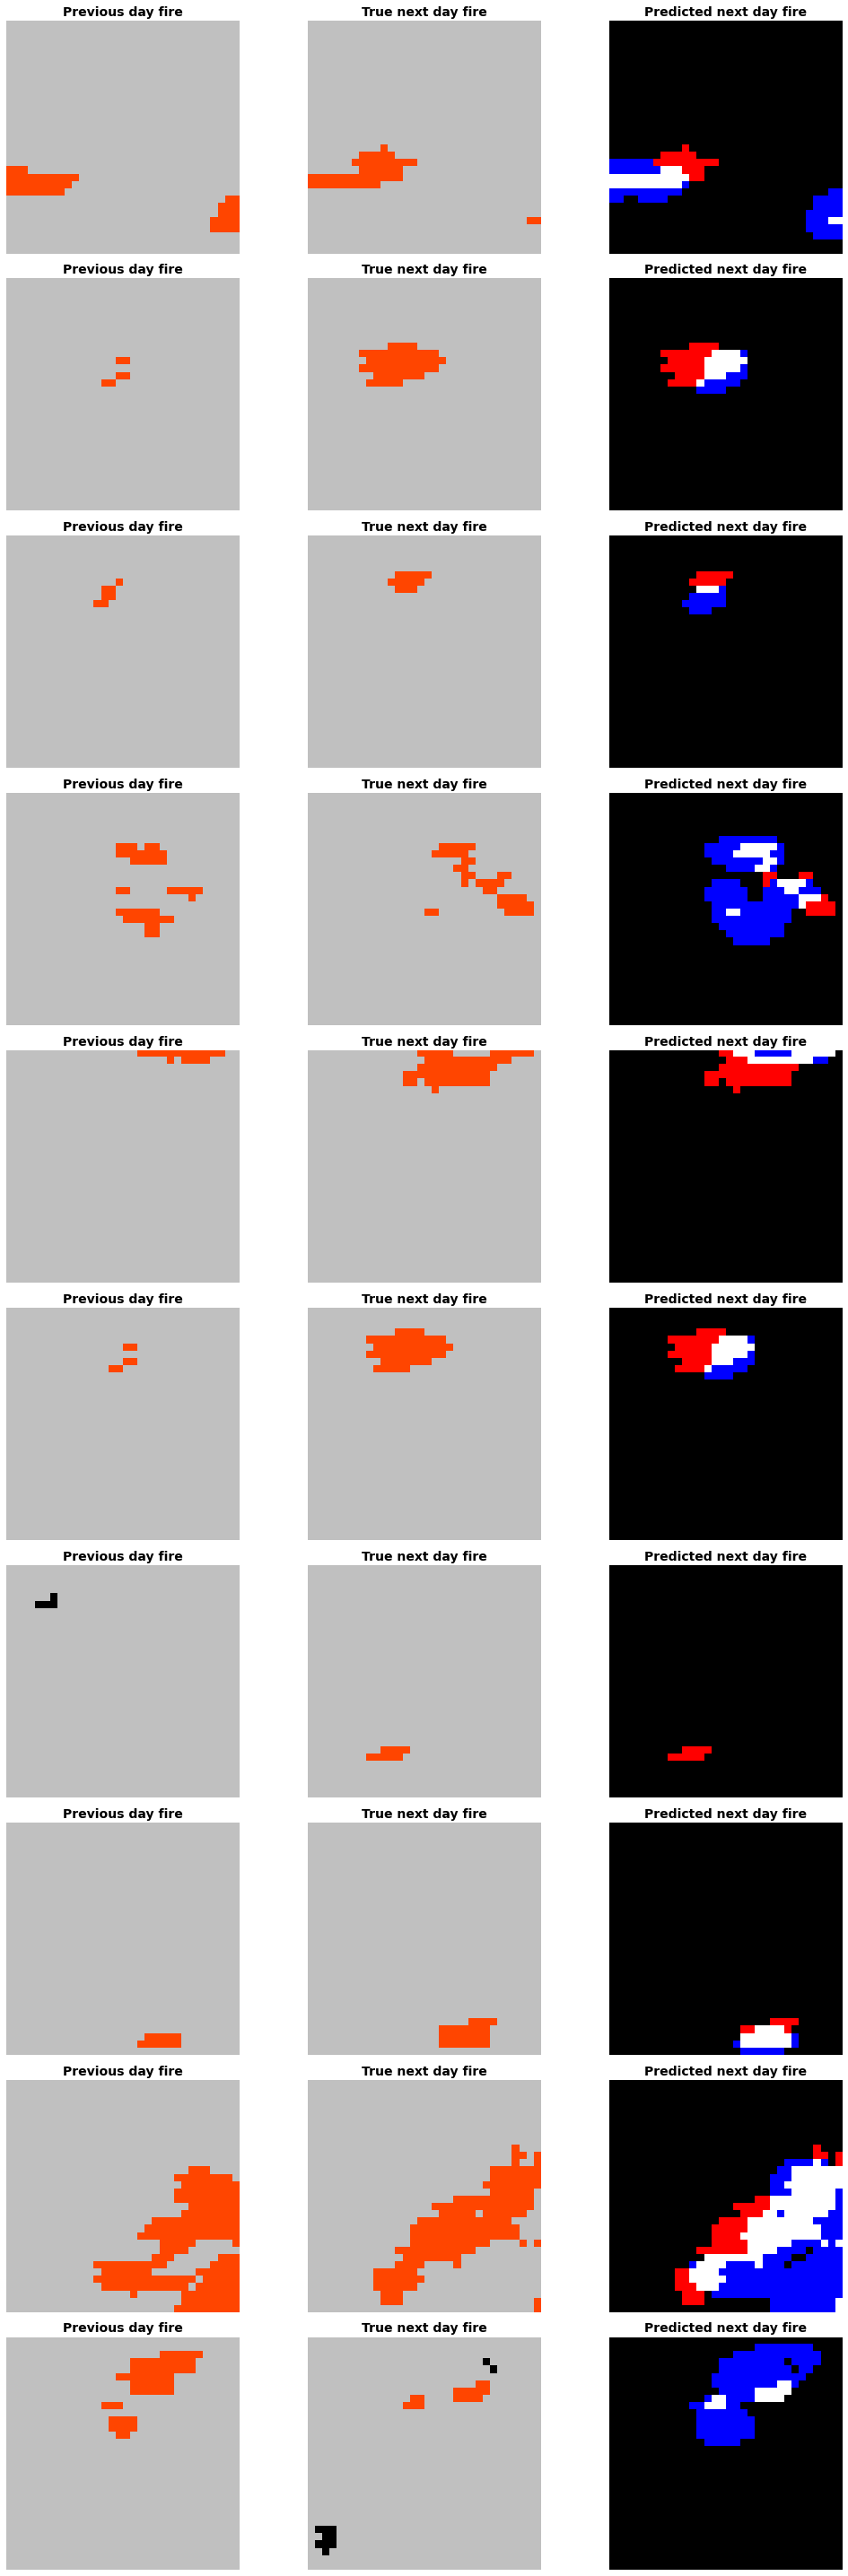

In [14]:
# Inference on test set
def show_inference(n_rows: int, features: tf.Tensor, label: tf.Tensor, prediction_function: Callable[[tf.Tensor], tf.Tensor]) -> None:
    """
    Show model inference through images.

    Args:
        n_rows (int): Number of rows for subplots.
        features (tf.Tensor): Input features.
        label (tf.Tensor): True labels.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """

    # Variables for controlling the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    fig = plt.figure(figsize=(15, n_rows*4))

    prediction = prediction_function(features)


    # print shape info
    print(f"Features shape: {features.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Prediction shape: {prediction.shape}")

    # Print some of the true and predicted labels of the first sample as a validation
    print(f"Example true labels (sample 0):\n{label[0, :, :, 0]}")
    print(f"Example predicted labels (sample 0):\n{prediction[0, :, :]}")


    for i in range(n_rows):
        plt.subplot(n_rows, 3, i*3 + 1)
        plt.title("Previous day fire", fontdict={'fontsize': 14, 'fontweight': 'bold'})
        plt.imshow(features[i, :, :, -1], cmap=CMAP, norm=NORM)
        plt.axis('off')

        plt.subplot(n_rows, 3, i*3 + 2)
        plt.title("True next day fire", fontdict={'fontsize': 14, 'fontweight': 'bold'})
        plt.imshow(label[i, :, :, 0], cmap=CMAP, norm=NORM)
        plt.axis('off')

        plt.subplot(n_rows, 3, i*3 + 3)
        plt.title("Predicted next day fire", fontdict={'fontsize': 14, 'fontweight': 'bold'})
        # plt.imshow(prediction[i, :, :])
        true_labels = label[i, :, :, 0]  # Shape: (height, width)
        predicted_labels = prediction[i, :, :]  # Shape: (height, width)

        # Create an image to show TP, FP, and FN
        tp = np.logical_and(predicted_labels == 1, true_labels == 1)
        fp = np.logical_and(predicted_labels == 1, true_labels == 0)
        fn = np.logical_and(predicted_labels == 0, true_labels == 1)

        result = np.zeros((true_labels.shape[0], true_labels.shape[1], 3))

        # Set colors:
        result[tp] = [1, 1, 1]  # White for True Positives
        result[fp] = [0, 0, 1]  # Blue for False Positives
        result[fn] = [1, 0, 0]  # Red for False Negatives

        plt.imshow(result)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("Unet_6fetature_Inference.png")

features, labels = next(iter(test_dataset))
show_inference(10, features, labels, lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:,:,:,0])